In [1]:
import tensorflow as tf
import numpy as np
seed = 123
np.random.seed(seed)
import cifar10_utils
import keras
from keras.models import Sequential
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.datasets import cifar10
from keras import regularizers, optimizers
from keras.applications import VGG16
import itertools

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

#z-score
mean = np.mean(x_train,axis=(0,1,2,3))
std = np.std(x_train,axis=(0,1,2,3))
x_train = (x_train-mean)/(std+1e-7)
x_test = (x_test-mean)/(std+1e-7)

#data augmentation
datagen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=False
    )

num_classes = 10
image_shape = x_train.shape[1:]

#training parameters
batch_size = 100
base_epochs = 10
baseMapNum = 32
weight_decay = 1e-4
class_names = ['other', 'airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


model = cifar10_utils.create_base_model(image_shape, baseMapNum, weight_decay, 'kaggle')
model.summary()
initial_weights = model.get_weights()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
__________

===============BASELINE Results On All Classes===========
selected classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Running Instance 0: 

======Training From Scratch=========

current other class: []
current target class: [ 1  2  3  4  5  6  7  8  9 10]
all target target class: [ 1  2  3  4  5  6  7  8  9 10]
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 0
accuracy on training from scrach: [0.9110000014305115, 0.9450000047683715, 0.752999997138977, 0.6899999976158142, 0.864000004529953, 0.8060000002384186, 0.9200000047683716, 0.8909999966621399, 0.935999995470047, 0.8819999933242798]


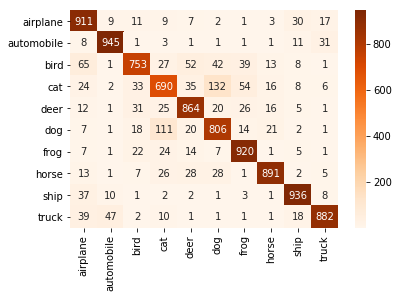

Running Instance 1: 

======Training From Scratch=========

current other class: []
current target class: [ 1  2  3  4  5  6  7  8  9 10]
all target target class: [ 1  2  3  4  5  6  7  8  9 10]
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 0
accuracy on training from scrach: [0.9269999980926513, 0.9450000107288361, 0.7639999985694885, 0.7419999897480011, 0.8660000085830688, 0.7030000030994416, 0.8959999978542328, 0.8740000009536744, 0.9280000030994415, 0.8309999942779541]


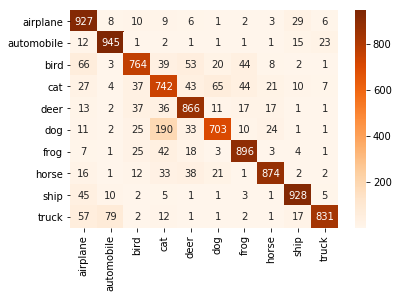

Running Instance 2: 

======Training From Scratch=========

current other class: []
current target class: [ 1  2  3  4  5  6  7  8  9 10]
all target target class: [ 1  2  3  4  5  6  7  8  9 10]
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 0
accuracy on training from scrach: [0.9330000042915344, 0.928000009059906, 0.7379999995231629, 0.7070000052452088, 0.8740000009536744, 0.7580000102519989, 0.9180000066757202, 0.9079999983310699, 0.9070000052452087, 0.8749999940395355]


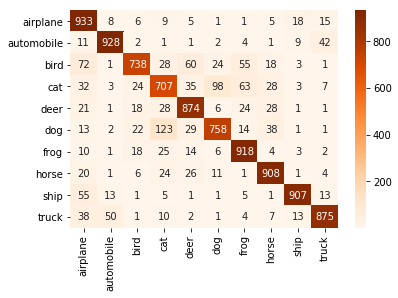

Running Instance 3: 

======Training From Scratch=========

current other class: []
current target class: [ 1  2  3  4  5  6  7  8  9 10]
all target target class: [ 1  2  3  4  5  6  7  8  9 10]
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 0
accuracy on training from scrach: [0.9300000071525574, 0.9350000083446502, 0.753000009059906, 0.7010000050067902, 0.8460000038146973, 0.8009999871253968, 0.9199999928474426, 0.9159999966621399, 0.9230000019073487, 0.8810000061988831]


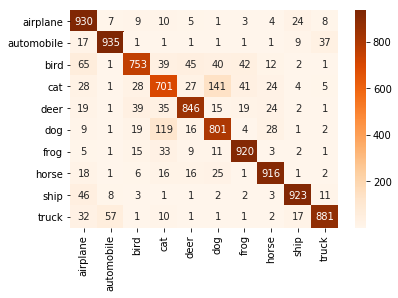

Running Instance 4: 

======Training From Scratch=========

current other class: []
current target class: [ 1  2  3  4  5  6  7  8  9 10]
all target target class: [ 1  2  3  4  5  6  7  8  9 10]
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 0
accuracy on training from scrach: [0.9060000121593476, 0.9540000021457672, 0.7650000035762787, 0.6370000064373016, 0.8620000004768371, 0.8069999933242797, 0.9430000066757203, 0.8629999995231629, 0.9180000066757202, 0.8230000019073487]


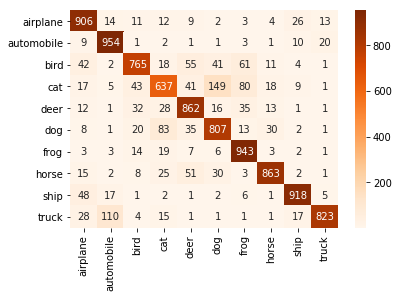

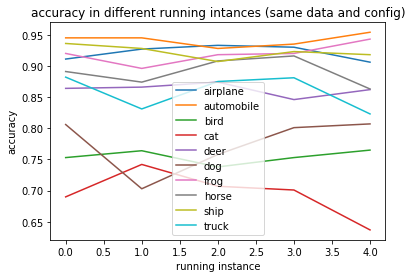

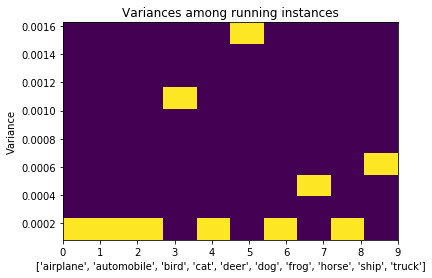

In [3]:
print('===============BASELINE Results On All Classes===========')

num_classes_excluding_other = 10
full_class_ids = np.arange(1, 11)  # 1-10

full_target_class_ids = full_class_ids[:num_classes_excluding_other]
selected_class_names = [class_names[el] for el in full_target_class_ids]
print('selected classes: ' + str(selected_class_names))

cur_target_class_ids = np.copy(full_target_class_ids)

n_running_instance = 5
baseline_results = []
for i in range(n_running_instance):
    print('Running Instance ' + str(i) + ': ')
    baseline_result,_,_ = cifar10_utils.one_run(model, x_train, y_train, x_test, y_test, batch_size, 
                      full_target_class_ids, initial_weights, base_epochs, class_names, GC=False)
    baseline_results += [baseline_result]
baseline_results = np.array(baseline_results)


for i, class_name in enumerate(selected_class_names):
    plt.plot(np.arange(n_running_instance), baseline_results[:, i], label=class_name)
plt.title('accuracy in different running intances (same data and config)')
plt.xlabel('running instance')
plt.ylabel('accuracy')
plt.legend()
plt.show()

# variance for each class among running instances
baseline_results_var = np.var(baseline_results, axis=0)
# plot variances of each class on different instances
plt.hist2d(range(len(selected_class_names)), baseline_results_var)
plt.title('Variances among running instances')
plt.xlabel(str(selected_class_names))
plt.ylabel('Variance')
plt.show()

In [4]:
model.save('baseline_results_on_all_classes_early_stopping.h5')

selected classes: ['automobile', 'cat', 'dog', 'truck']

======Training From Scratch=========

current other class: [1 3 5 7 8 9]
current target class: [ 2  4  6 10]
all target target class: [ 2  4  6 10]
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 30000
accuracy on training from scrach: [0.9429999947547912, 0.70799999833107, 0.8509999990463257, 0.9250000178813934]


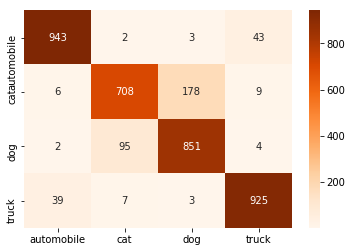

sequence of class addition: ['automobile', 'cat', 'dog', 'truck']

=====Training Using Growing Classifier (new classes appeared in 'Other' class before) ======

current other class: [ 1  3  4  5  6  7  8  9 10]
current target class: (2,)
all target target class: (2, 4, 6, 10)
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 45000
-----Fine Tuning------
Epoch 00007: early stopping
GC (refining) accuracy on sequence ['automobile']: [0.967000013589859]


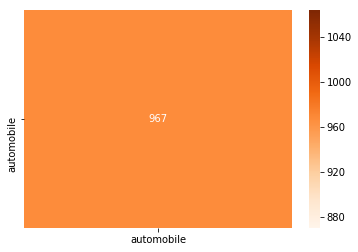

-----Adding a new class cat (total classes including other: 3)------
current other class: [ 1  3  5  6  7  8  9 10]
current target class: (2, 4)
all target target class: (2, 4, 6, 10)
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 40000
-----Fine Tuning------
Epoch 00006: early stopping
GC (refining) accuracy on sequence ['automobile', 'cat']: [0.9260000050067901, 0.9770000100135803]


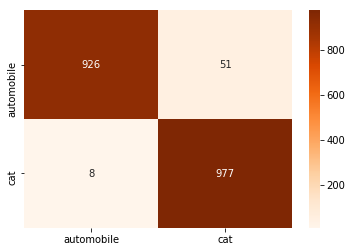

-----Adding a new class dog (total classes including other: 4)------
current other class: [ 1  3  5  7  8  9 10]
current target class: (2, 4, 6)
all target target class: (2, 4, 6, 10)
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 35000
-----Fine Tuning------
GC (refining) accuracy on sequence ['automobile', 'cat', 'dog']: [0.9079999983310699, 0.6150000035762787, 0.6130000054836273]


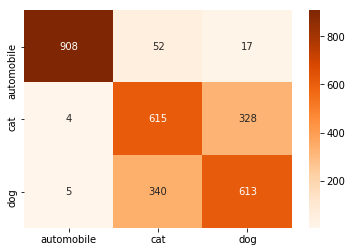

-----Adding a new class truck (total classes including other: 5)------
current other class: [1 3 5 7 8 9]
current target class: (2, 4, 6, 10)
all target target class: (2, 4, 6, 10)
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 30000
-----Fine Tuning------
Epoch 00006: early stopping
GC (refining) accuracy on sequence ['automobile', 'cat', 'dog', 'truck']: [0.7739999890327454, 0.7070000112056732, 0.5159999996423721, 0.7700000047683716]


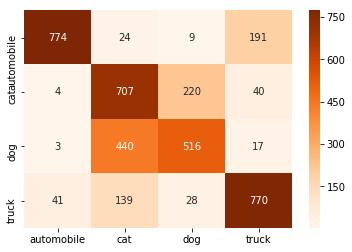


=====Training Using Growing Classifier (new classes never appeared in 'Other' class before) ======

current other class: [1 3 5 7 8 9]
current target class: (2,)
all target target class: (2, 4, 6, 10)
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 30000
-----Fine Tuning------
Epoch 00006: early stopping
GC (without refining) accuracy on sequence ['automobile']: [0.9810000121593475]


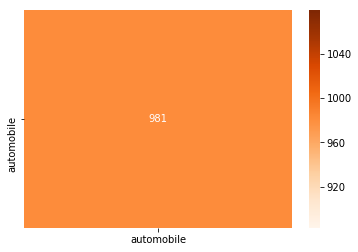

-----Adding a new class cat (total classes including other: 3)------
current other class: [1 3 5 7 8 9]
current target class: (2, 4)
all target target class: (2, 4, 6, 10)
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 30000
-----Fine Tuning------
Epoch 00006: early stopping
GC (without refining) accuracy on sequence ['automobile', 'cat']: [0.9179999947547912, 0.9589999914169312]


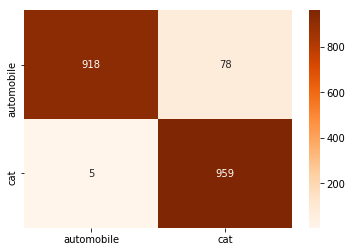

-----Adding a new class dog (total classes including other: 4)------
current other class: [1 3 5 7 8 9]
current target class: (2, 4, 6)
all target target class: (2, 4, 6, 10)
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 30000
-----Fine Tuning------
GC (without refining) accuracy on sequence ['automobile', 'cat', 'dog']: [0.9060000061988831, 0.4619999974966049, 0.5619999885559082]


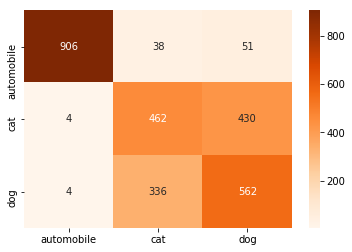

-----Adding a new class truck (total classes including other: 5)------
current other class: [1 3 5 7 8 9]
current target class: (2, 4, 6, 10)
all target target class: (2, 4, 6, 10)
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 30000
-----Fine Tuning------
GC (without refining) accuracy on sequence ['automobile', 'cat', 'dog', 'truck']: [0.5860000014305115, 0.5949999988079071, 0.489000004529953, 0.6300000011920929]


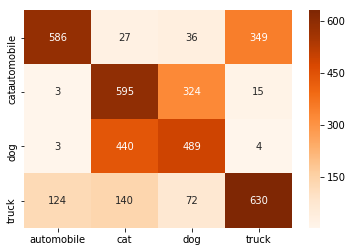

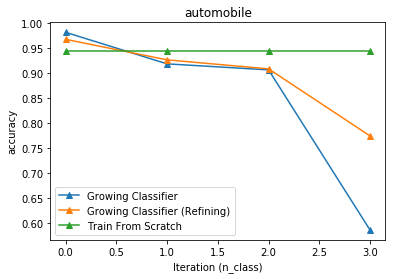

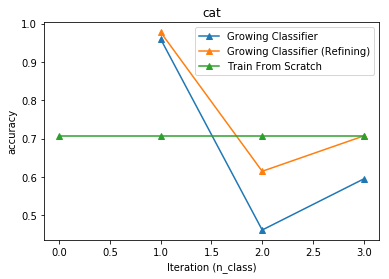

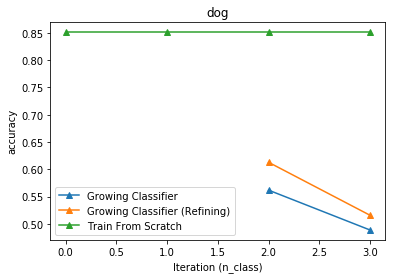

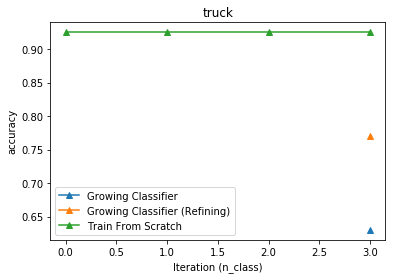

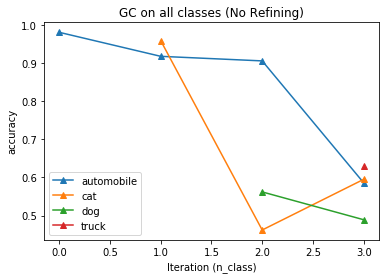

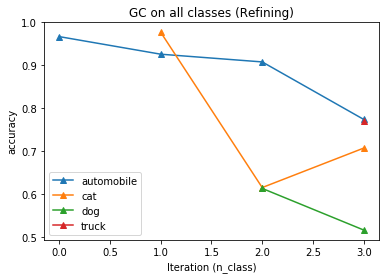

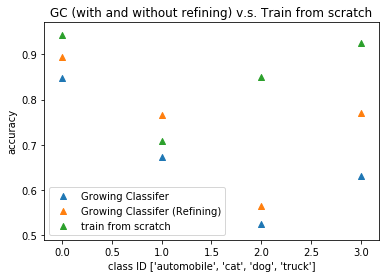

sequence of class addition: ['automobile', 'cat', 'truck', 'dog']

=====Training Using Growing Classifier (new classes appeared in 'Other' class before) ======

current other class: [ 1  3  4  5  6  7  8  9 10]
current target class: (2,)
all target target class: (2, 4, 10, 6)
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 45000
-----Fine Tuning------
GC (refining) accuracy on sequence ['automobile']: [0.9349999964237213]


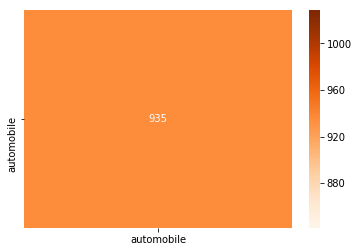

-----Adding a new class cat (total classes including other: 3)------
current other class: [ 1  3  5  6  7  8  9 10]
current target class: (2, 4)
all target target class: (2, 4, 10, 6)
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 40000
-----Fine Tuning------
Epoch 00009: early stopping
GC (refining) accuracy on sequence ['automobile', 'cat']: [0.8879999935626983, 0.8980000078678131]


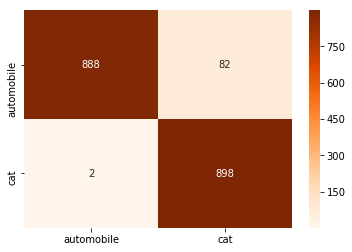

-----Adding a new class truck (total classes including other: 4)------
current other class: [1 3 5 6 7 8 9]
current target class: (2, 4, 10)
all target target class: (2, 4, 10, 6)
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 35000
-----Fine Tuning------
Epoch 00010: early stopping
GC (refining) accuracy on sequence ['automobile', 'cat', 'truck']: [0.847000002861023, 0.8960000038146972, 0.6890000104904175]


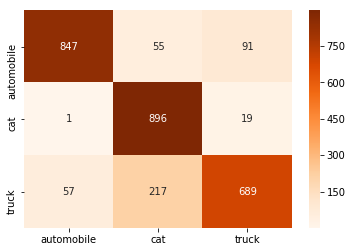

-----Adding a new class dog (total classes including other: 5)------
current other class: [1 3 5 7 8 9]
current target class: (2, 4, 10, 6)
all target target class: (2, 4, 10, 6)
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 30000
-----Fine Tuning------
GC (refining) accuracy on sequence ['automobile', 'cat', 'truck', 'dog']: [0.8099999904632569, 0.6329999983310699, 0.6340000033378601, 0.568999993801117]


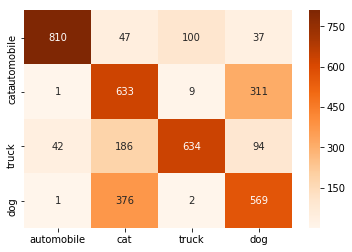


=====Training Using Growing Classifier (new classes never appeared in 'Other' class before) ======

current other class: [1 3 5 7 8 9]
current target class: (2,)
all target target class: (2, 4, 10, 6)
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 30000
-----Fine Tuning------
Epoch 00010: early stopping
GC (without refining) accuracy on sequence ['automobile']: [0.964000004529953]


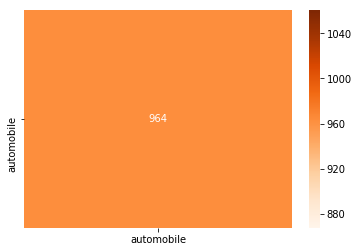

-----Adding a new class cat (total classes including other: 3)------
current other class: [1 3 5 7 8 9]
current target class: (2, 4)
all target target class: (2, 4, 10, 6)
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 30000
-----Fine Tuning------
GC (without refining) accuracy on sequence ['automobile', 'cat']: [0.9369999945163727, 0.8689999997615814]


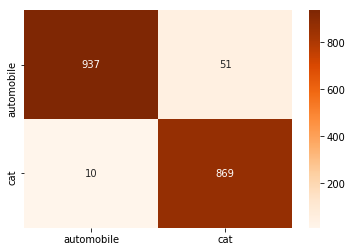

-----Adding a new class truck (total classes including other: 4)------
current other class: [1 3 5 7 8 9]
current target class: (2, 4, 10)
all target target class: (2, 4, 10, 6)
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 30000
-----Fine Tuning------
Epoch 00008: early stopping
GC (without refining) accuracy on sequence ['automobile', 'cat', 'truck']: [0.725, 0.9159999966621399, 0.6349999964237213]


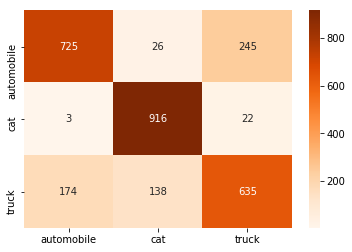

-----Adding a new class dog (total classes including other: 5)------
current other class: [1 3 5 7 8 9]
current target class: (2, 4, 10, 6)
all target target class: (2, 4, 10, 6)
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 30000
-----Fine Tuning------
Epoch 00008: early stopping
GC (without refining) accuracy on sequence ['automobile', 'cat', 'truck', 'dog']: [0.7089999914169312, 0.6349999964237213, 0.6300000011920929, 0.48100000321865083]


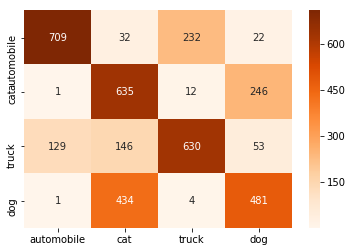

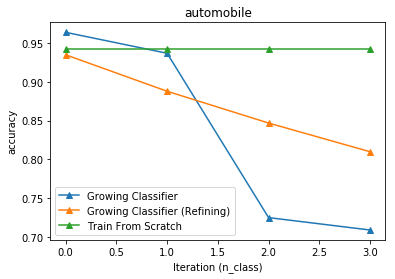

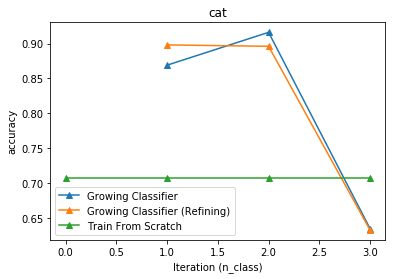

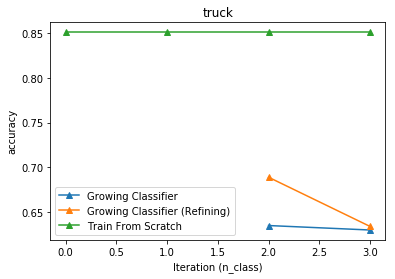

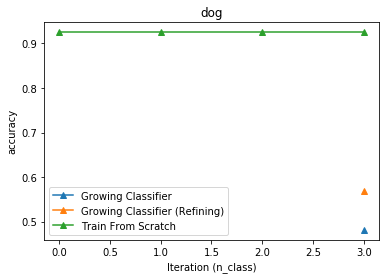

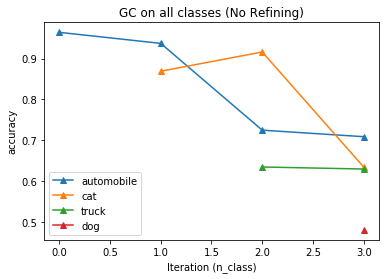

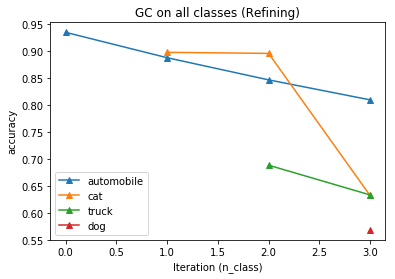

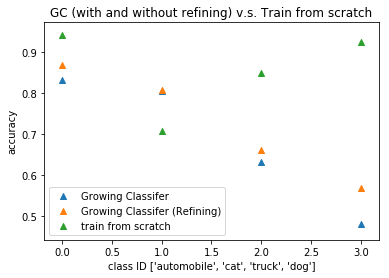

sequence of class addition: ['automobile', 'dog', 'cat', 'truck']

=====Training Using Growing Classifier (new classes appeared in 'Other' class before) ======

current other class: [ 1  3  4  5  6  7  8  9 10]
current target class: (2,)
all target target class: (2, 6, 4, 10)
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 45000
-----Fine Tuning------
Epoch 00010: early stopping
GC (refining) accuracy on sequence ['automobile']: [0.9470000028610229]


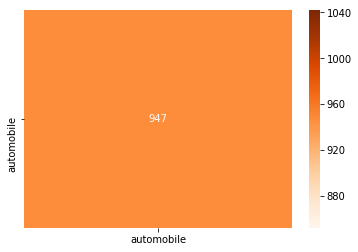

-----Adding a new class dog (total classes including other: 3)------
current other class: [ 1  3  4  5  7  8  9 10]
current target class: (2, 6)
all target target class: (2, 6, 4, 10)
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 40000
-----Fine Tuning------
Epoch 00010: early stopping
GC (refining) accuracy on sequence ['automobile', 'dog']: [0.8980000019073486, 0.9300000011920929]


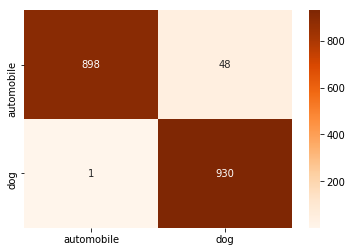

-----Adding a new class cat (total classes including other: 4)------
current other class: [ 1  3  5  7  8  9 10]
current target class: (2, 6, 4)
all target target class: (2, 6, 4, 10)
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 35000
-----Fine Tuning------
Epoch 00007: early stopping
GC (refining) accuracy on sequence ['automobile', 'dog', 'cat']: [0.8489999890327453, 0.6499999940395356, 0.6159999966621399]


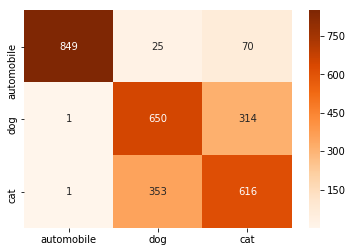

-----Adding a new class truck (total classes including other: 5)------
current other class: [1 3 5 7 8 9]
current target class: (2, 6, 4, 10)
all target target class: (2, 6, 4, 10)
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 30000
-----Fine Tuning------
Epoch 00006: early stopping
GC (refining) accuracy on sequence ['automobile', 'dog', 'cat', 'truck']: [0.789000004529953, 0.6619999945163727, 0.6060000061988831, 0.7230000019073486]


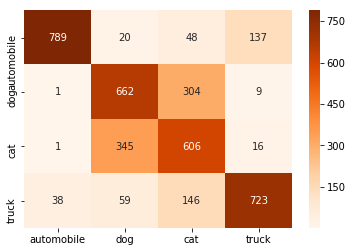


=====Training Using Growing Classifier (new classes never appeared in 'Other' class before) ======

current other class: [1 3 5 7 8 9]
current target class: (2,)
all target target class: (2, 6, 4, 10)
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 30000
-----Fine Tuning------
Epoch 00006: early stopping
GC (without refining) accuracy on sequence ['automobile']: [0.9770000159740448]


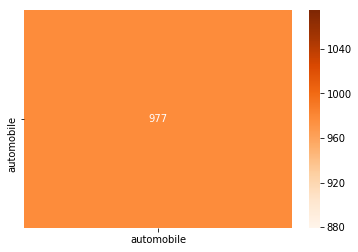

-----Adding a new class dog (total classes including other: 3)------
current other class: [1 3 5 7 8 9]
current target class: (2, 6)
all target target class: (2, 6, 4, 10)
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 30000
-----Fine Tuning------
Epoch 00008: early stopping
GC (without refining) accuracy on sequence ['automobile', 'dog']: [0.939000004529953, 0.8539999961853028]


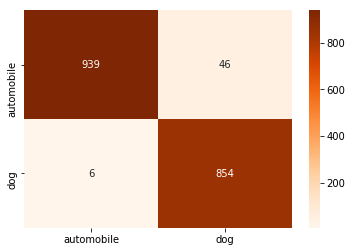

-----Adding a new class cat (total classes including other: 4)------
current other class: [1 3 5 7 8 9]
current target class: (2, 6, 4)
all target target class: (2, 6, 4, 10)
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 30000
-----Fine Tuning------
GC (without refining) accuracy on sequence ['automobile', 'dog', 'cat']: [0.9130000054836274, 0.7719999969005584, 0.35800000131130216]


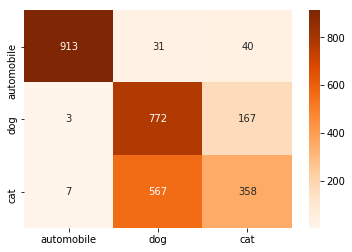

-----Adding a new class truck (total classes including other: 5)------
current other class: [1 3 5 7 8 9]
current target class: (2, 6, 4, 10)
all target target class: (2, 6, 4, 10)
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 30000
-----Fine Tuning------
GC (without refining) accuracy on sequence ['automobile', 'dog', 'cat', 'truck']: [0.7180000007152557, 0.49500000178813935, 0.6259999990463256, 0.6970000028610229]


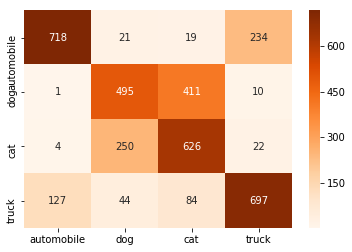

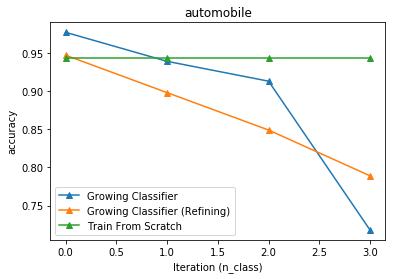

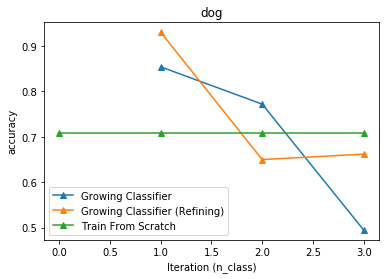

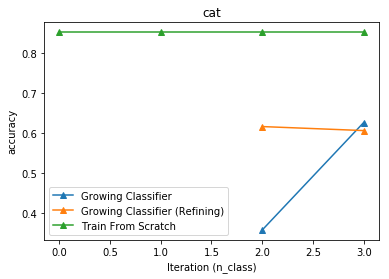

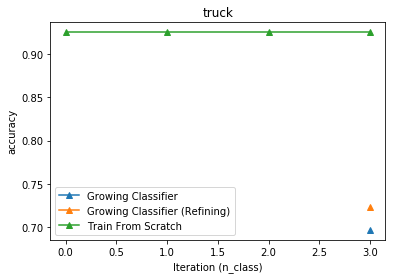

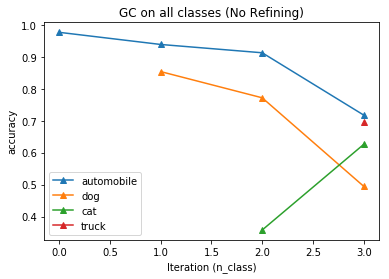

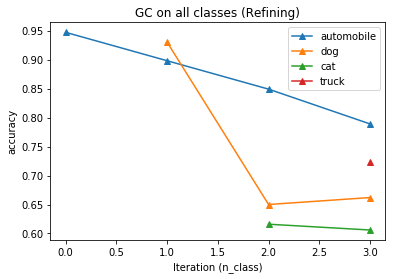

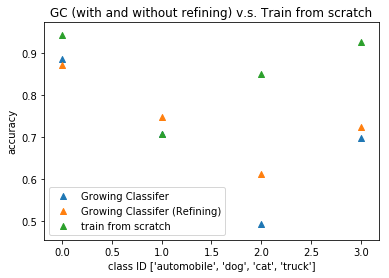

sequence of class addition: ['automobile', 'dog', 'truck', 'cat']

=====Training Using Growing Classifier (new classes appeared in 'Other' class before) ======

current other class: [ 1  3  4  5  6  7  8  9 10]
current target class: (2,)
all target target class: (2, 6, 10, 4)
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 45000
-----Fine Tuning------
Epoch 00009: early stopping
GC (refining) accuracy on sequence ['automobile']: [0.975000011920929]


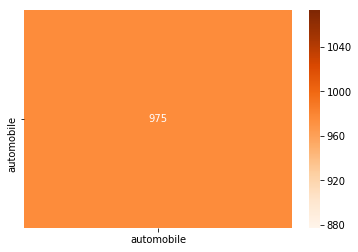

-----Adding a new class dog (total classes including other: 3)------
current other class: [ 1  3  4  5  7  8  9 10]
current target class: (2, 6)
all target target class: (2, 6, 10, 4)
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 40000
-----Fine Tuning------
Epoch 00010: early stopping
GC (refining) accuracy on sequence ['automobile', 'dog']: [0.928000009059906, 0.9800000011920929]


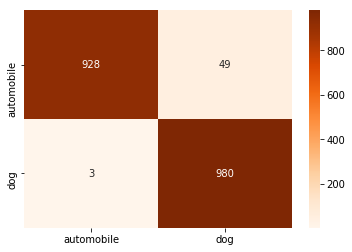

-----Adding a new class truck (total classes including other: 4)------
current other class: [1 3 4 5 7 8 9]
current target class: (2, 6, 10)
all target target class: (2, 6, 10, 4)
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 35000
-----Fine Tuning------
Epoch 00006: early stopping
GC (refining) accuracy on sequence ['automobile', 'dog', 'truck']: [0.8029999971389771, 0.9610000073909759, 0.80799999833107]


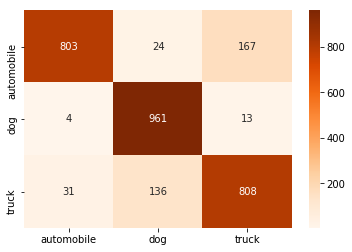

-----Adding a new class cat (total classes including other: 5)------
current other class: [1 3 5 7 8 9]
current target class: (2, 6, 10, 4)
all target target class: (2, 6, 10, 4)
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 30000
-----Fine Tuning------
Epoch 00008: early stopping
GC (refining) accuracy on sequence ['automobile', 'dog', 'truck', 'cat']: [0.85, 0.814000004529953, 0.7150000095367431, 0.3190000057220459]


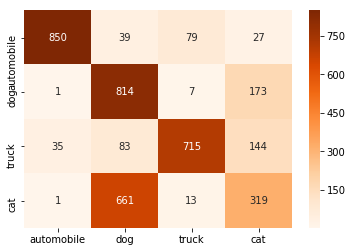


=====Training Using Growing Classifier (new classes never appeared in 'Other' class before) ======

current other class: [1 3 5 7 8 9]
current target class: (2,)
all target target class: (2, 6, 10, 4)
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 30000
-----Fine Tuning------
Epoch 00008: early stopping
GC (without refining) accuracy on sequence ['automobile']: [0.9750000059604644]


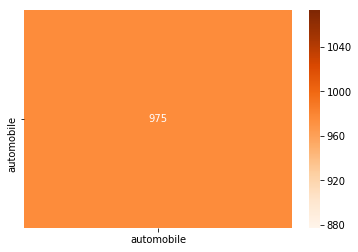

-----Adding a new class dog (total classes including other: 3)------
current other class: [1 3 5 7 8 9]
current target class: (2, 6)
all target target class: (2, 6, 10, 4)
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 30000
-----Fine Tuning------
Epoch 00007: early stopping
GC (without refining) accuracy on sequence ['automobile', 'dog']: [0.8919999957084656, 0.9840000152587891]


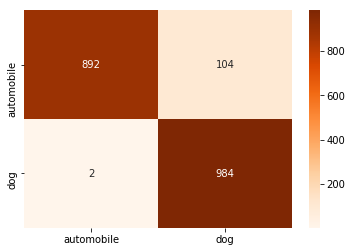

-----Adding a new class truck (total classes including other: 4)------
current other class: [1 3 5 7 8 9]
current target class: (2, 6, 10)
all target target class: (2, 6, 10, 4)
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 30000
-----Fine Tuning------
GC (without refining) accuracy on sequence ['automobile', 'dog', 'truck']: [0.5469999939203263, 0.9569999933242798, 0.6990000009536743]


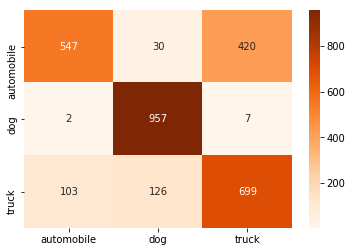

-----Adding a new class cat (total classes including other: 5)------
current other class: [1 3 5 7 8 9]
current target class: (2, 6, 10, 4)
all target target class: (2, 6, 10, 4)
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 30000
-----Fine Tuning------
Epoch 00010: early stopping
GC (without refining) accuracy on sequence ['automobile', 'dog', 'truck', 'cat']: [0.5629999965429306, 0.8479999959468841, 0.6300000011920929, 0.2280000001192093]


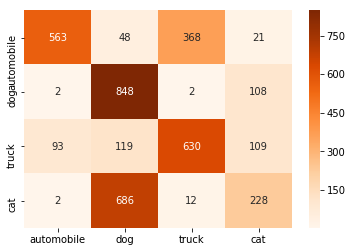

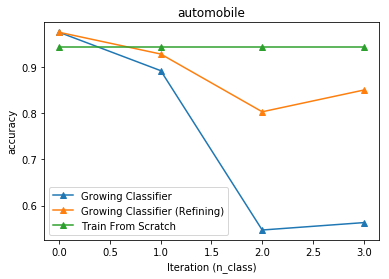

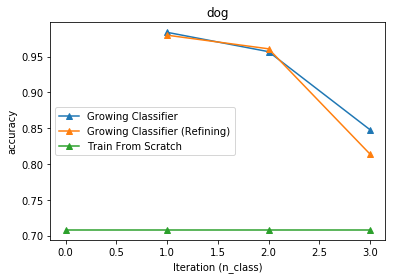

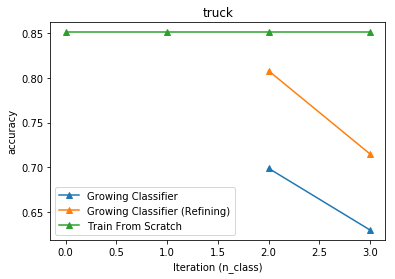

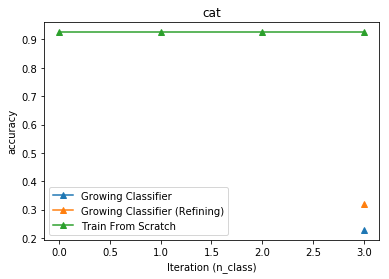

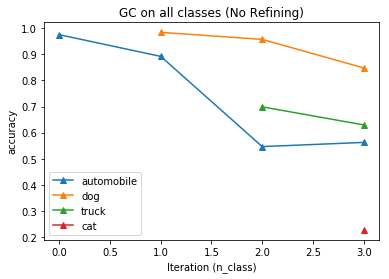

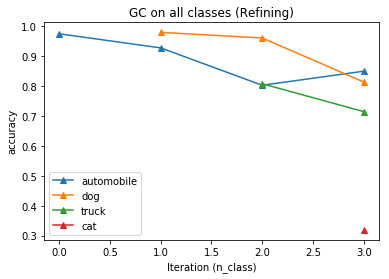

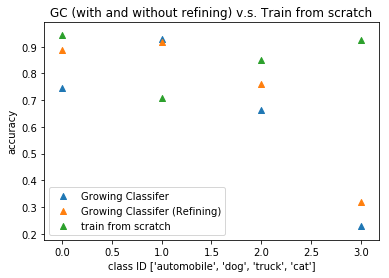

sequence of class addition: ['automobile', 'truck', 'cat', 'dog']

=====Training Using Growing Classifier (new classes appeared in 'Other' class before) ======

current other class: [ 1  3  4  5  6  7  8  9 10]
current target class: (2,)
all target target class: (2, 10, 4, 6)
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 45000
-----Fine Tuning------
Epoch 00007: early stopping
GC (refining) accuracy on sequence ['automobile']: [0.9490000009536743]


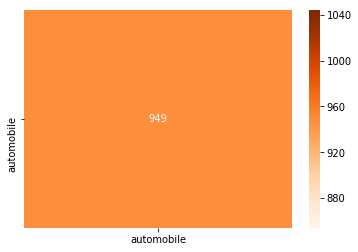

-----Adding a new class truck (total classes including other: 3)------
current other class: [1 3 4 5 6 7 8 9]
current target class: (2, 10)
all target target class: (2, 10, 4, 6)
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 40000
-----Fine Tuning------
Epoch 00006: early stopping
GC (refining) accuracy on sequence ['automobile', 'truck']: [0.8699999988079071, 0.8760000050067902]


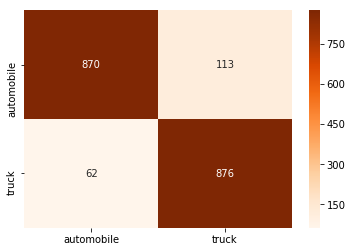

-----Adding a new class cat (total classes including other: 4)------
current other class: [1 3 5 6 7 8 9]
current target class: (2, 10, 4)
all target target class: (2, 10, 4, 6)
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 35000
-----Fine Tuning------
GC (refining) accuracy on sequence ['automobile', 'truck', 'cat']: [0.8370000004768372, 0.8159999907016754, 0.8740000069141388]


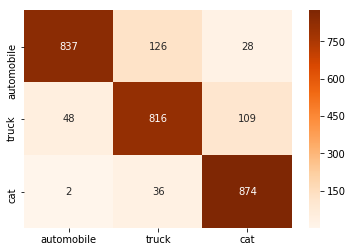

-----Adding a new class dog (total classes including other: 5)------
current other class: [1 3 5 7 8 9]
current target class: (2, 10, 4, 6)
all target target class: (2, 10, 4, 6)
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 30000
-----Fine Tuning------
Epoch 00008: early stopping
GC (refining) accuracy on sequence ['automobile', 'truck', 'cat', 'dog']: [0.7999999940395355, 0.7219999969005585, 0.510999995470047, 0.6990000009536743]


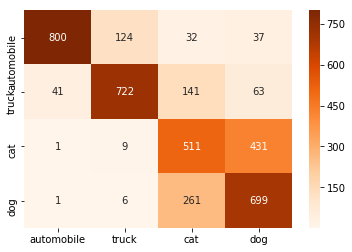


=====Training Using Growing Classifier (new classes never appeared in 'Other' class before) ======

current other class: [1 3 5 7 8 9]
current target class: (2,)
all target target class: (2, 10, 4, 6)
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 30000
-----Fine Tuning------
Epoch 00010: early stopping
GC (without refining) accuracy on sequence ['automobile']: [0.9590000092983246]


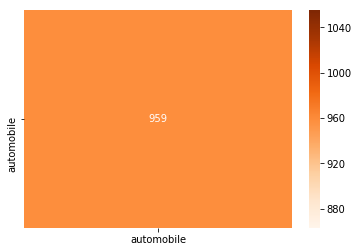

-----Adding a new class truck (total classes including other: 3)------
current other class: [1 3 5 7 8 9]
current target class: (2, 10)
all target target class: (2, 10, 4, 6)
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 30000
-----Fine Tuning------
Epoch 00008: early stopping
GC (without refining) accuracy on sequence ['automobile', 'truck']: [0.789000004529953, 0.69200000166893]


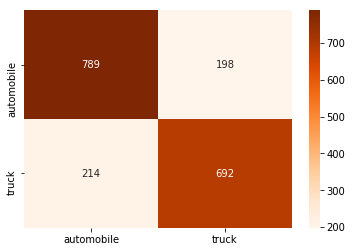

-----Adding a new class cat (total classes including other: 4)------
current other class: [1 3 5 7 8 9]
current target class: (2, 10, 4)
all target target class: (2, 10, 4, 6)
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 30000
-----Fine Tuning------
Epoch 00006: early stopping
GC (without refining) accuracy on sequence ['automobile', 'truck', 'cat']: [0.7299999952316284, 0.6510000050067901, 0.9270000040531159]


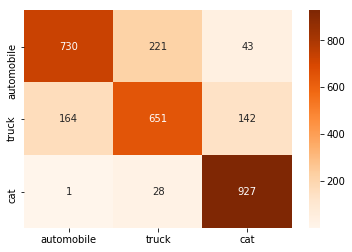

-----Adding a new class dog (total classes including other: 5)------
current other class: [1 3 5 7 8 9]
current target class: (2, 10, 4, 6)
all target target class: (2, 10, 4, 6)
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 30000
-----Fine Tuning------
GC (without refining) accuracy on sequence ['automobile', 'truck', 'cat', 'dog']: [0.6679999947547912, 0.6620000004768372, 0.4839999943971634, 0.6559999942779541]


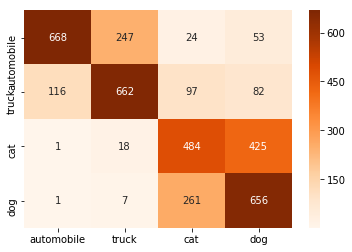

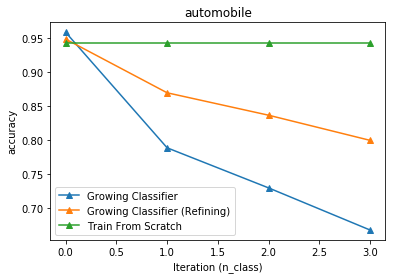

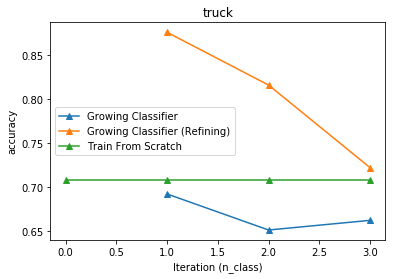

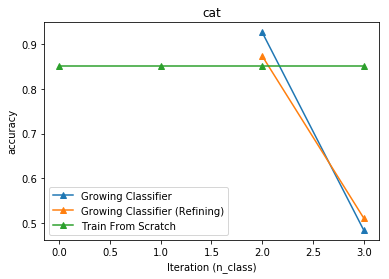

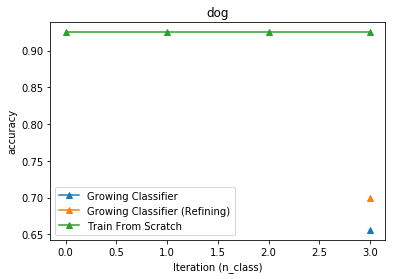

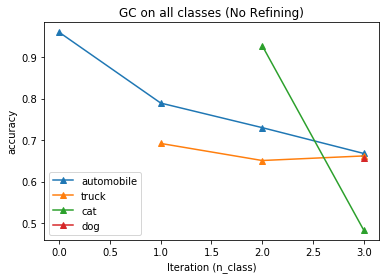

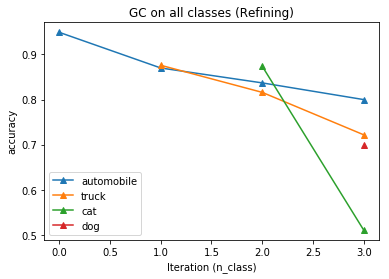

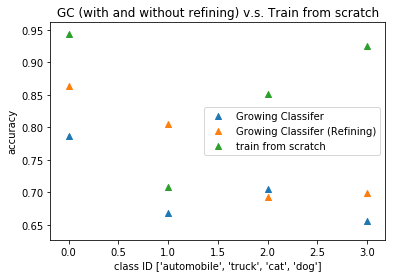

sequence of class addition: ['automobile', 'truck', 'dog', 'cat']

=====Training Using Growing Classifier (new classes appeared in 'Other' class before) ======

current other class: [ 1  3  4  5  6  7  8  9 10]
current target class: (2,)
all target target class: (2, 10, 6, 4)
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 45000
-----Fine Tuning------
Epoch 00010: early stopping
GC (refining) accuracy on sequence ['automobile']: [0.9630000114440918]


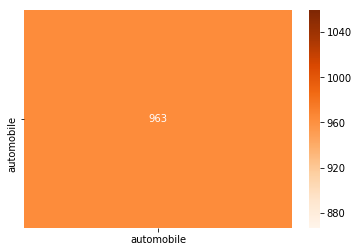

-----Adding a new class truck (total classes including other: 3)------
current other class: [1 3 4 5 6 7 8 9]
current target class: (2, 10)
all target target class: (2, 10, 6, 4)
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 40000
-----Fine Tuning------
GC (refining) accuracy on sequence ['automobile', 'truck']: [0.8650000035762787, 0.7800000011920929]


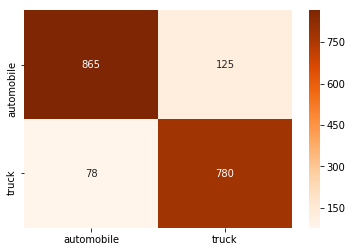

-----Adding a new class dog (total classes including other: 4)------
current other class: [1 3 4 5 7 8 9]
current target class: (2, 10, 6)
all target target class: (2, 10, 6, 4)
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 35000
-----Fine Tuning------
GC (refining) accuracy on sequence ['automobile', 'truck', 'dog']: [0.8289999902248383, 0.7879999995231628, 0.8280000030994416]


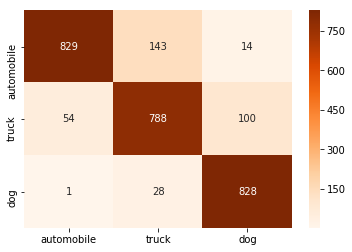

-----Adding a new class cat (total classes including other: 5)------
current other class: [1 3 5 7 8 9]
current target class: (2, 10, 6, 4)
all target target class: (2, 10, 6, 4)
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 30000
-----Fine Tuning------
Epoch 00010: early stopping
GC (refining) accuracy on sequence ['automobile', 'truck', 'dog', 'cat']: [0.8060000002384186, 0.6800000011920929, 0.5509999990463257, 0.6590000033378601]


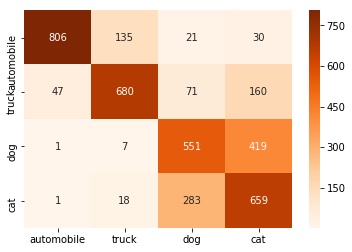


=====Training Using Growing Classifier (new classes never appeared in 'Other' class before) ======

current other class: [1 3 5 7 8 9]
current target class: (2,)
all target target class: (2, 10, 6, 4)
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 30000
-----Fine Tuning------
Epoch 00010: early stopping
GC (without refining) accuracy on sequence ['automobile']: [0.9800000131130219]


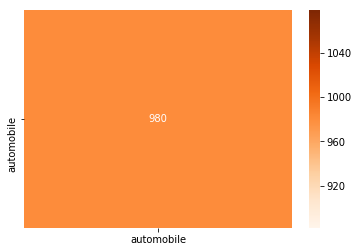

-----Adding a new class truck (total classes including other: 3)------
current other class: [1 3 5 7 8 9]
current target class: (2, 10)
all target target class: (2, 10, 6, 4)
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 30000
-----Fine Tuning------
GC (without refining) accuracy on sequence ['automobile', 'truck']: [0.7780000030994415, 0.6649999976158142]


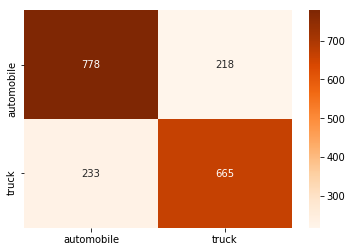

-----Adding a new class dog (total classes including other: 4)------
current other class: [1 3 5 7 8 9]
current target class: (2, 10, 6)
all target target class: (2, 10, 6, 4)
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 30000
-----Fine Tuning------
Epoch 00007: early stopping
GC (without refining) accuracy on sequence ['automobile', 'truck', 'dog']: [0.6789999902248383, 0.65, 0.9760000169277191]


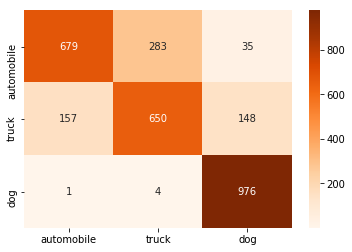

-----Adding a new class cat (total classes including other: 5)------
current other class: [1 3 5 7 8 9]
current target class: (2, 10, 6, 4)
all target target class: (2, 10, 6, 4)
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 30000
-----Fine Tuning------
GC (without refining) accuracy on sequence ['automobile', 'truck', 'dog', 'cat']: [0.5219999939203263, 0.6810000002384186, 0.37599999606609347, 0.7160000085830689]


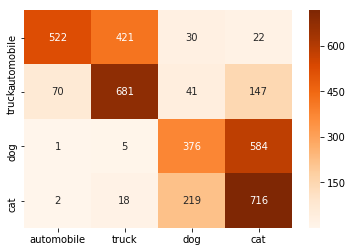

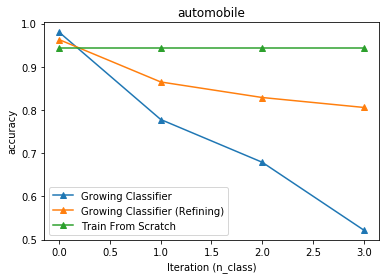

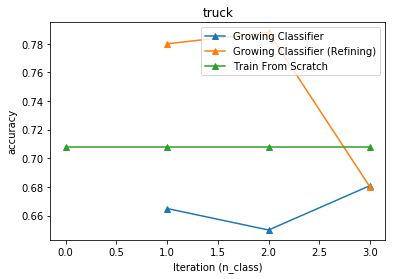

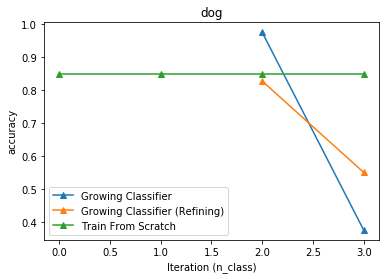

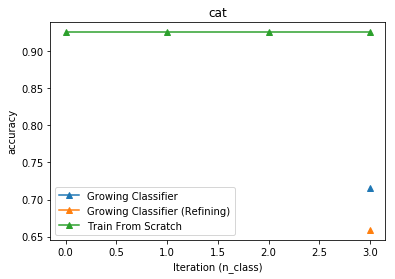

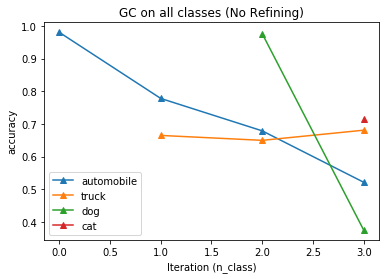

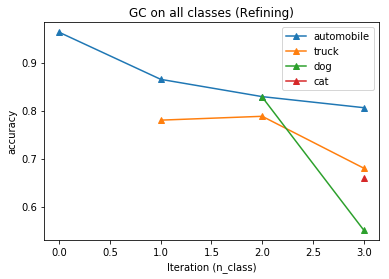

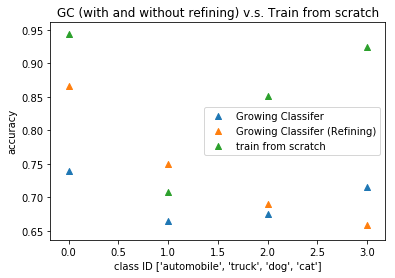

sequence of class addition: ['cat', 'automobile', 'dog', 'truck']

=====Training Using Growing Classifier (new classes appeared in 'Other' class before) ======

current other class: [ 1  2  3  5  6  7  8  9 10]
current target class: (4,)
all target target class: (4, 2, 6, 10)
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 45000
-----Fine Tuning------
GC (refining) accuracy on sequence ['cat']: [0.7949999988079071]


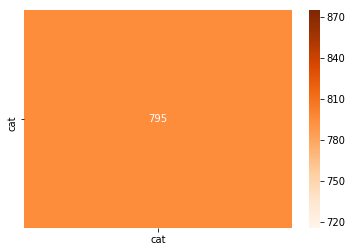

-----Adding a new class automobile (total classes including other: 3)------
current other class: [ 1  3  5  6  7  8  9 10]
current target class: (4, 2)
all target target class: (4, 2, 6, 10)
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 40000
-----Fine Tuning------
GC (refining) accuracy on sequence ['cat', 'automobile']: [0.7729999959468842, 0.9550000011920929]


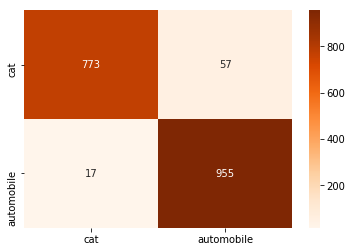

-----Adding a new class dog (total classes including other: 4)------
current other class: [ 1  3  5  7  8  9 10]
current target class: (4, 2, 6)
all target target class: (4, 2, 6, 10)
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 35000
-----Fine Tuning------
GC (refining) accuracy on sequence ['cat', 'automobile', 'dog']: [0.6359999895095825, 0.9039999961853027, 0.6449999928474426]


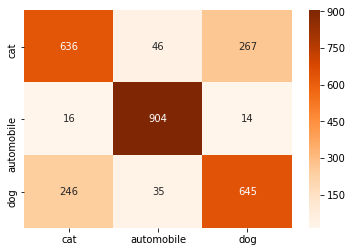

-----Adding a new class truck (total classes including other: 5)------
current other class: [1 3 5 7 8 9]
current target class: (4, 2, 6, 10)
all target target class: (4, 2, 6, 10)
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 30000
-----Fine Tuning------
GC (refining) accuracy on sequence ['cat', 'automobile', 'dog', 'truck']: [0.6400000035762787, 0.6560000002384185, 0.575, 0.7680000007152558]


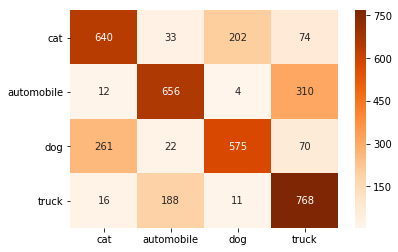


=====Training Using Growing Classifier (new classes never appeared in 'Other' class before) ======

current other class: [1 3 5 7 8 9]
current target class: (4,)
all target target class: (4, 2, 6, 10)
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 30000
-----Fine Tuning------
Epoch 00010: early stopping
GC (without refining) accuracy on sequence ['cat']: [0.8590000033378601]


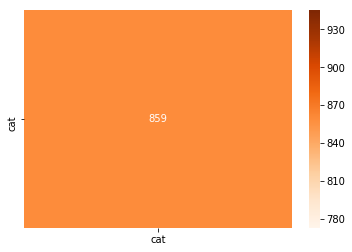

-----Adding a new class automobile (total classes including other: 3)------
current other class: [1 3 5 7 8 9]
current target class: (4, 2)
all target target class: (4, 2, 6, 10)
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 30000
-----Fine Tuning------
Epoch 00007: early stopping
GC (without refining) accuracy on sequence ['cat', 'automobile']: [0.8119999945163727, 0.8830000042915345]


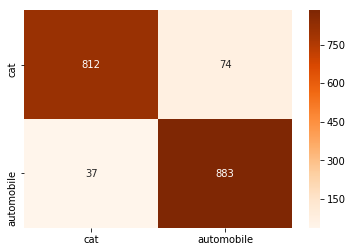

-----Adding a new class dog (total classes including other: 4)------
current other class: [1 3 5 7 8 9]
current target class: (4, 2, 6)
all target target class: (4, 2, 6, 10)
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 30000
-----Fine Tuning------
Epoch 00010: early stopping
GC (without refining) accuracy on sequence ['cat', 'automobile', 'dog']: [0.5809999942779541, 0.9349999964237213, 0.5609999924898148]


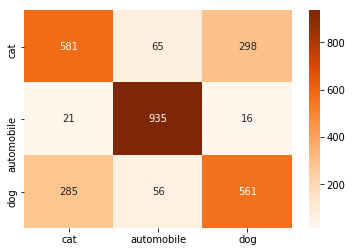

-----Adding a new class truck (total classes including other: 5)------
current other class: [1 3 5 7 8 9]
current target class: (4, 2, 6, 10)
all target target class: (4, 2, 6, 10)
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 30000
-----Fine Tuning------
GC (without refining) accuracy on sequence ['cat', 'automobile', 'dog', 'truck']: [0.5080000072717666, 0.7519999921321869, 0.5930000007152557, 0.6880000114440918]


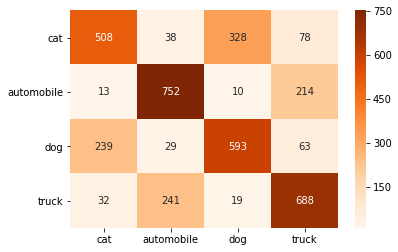

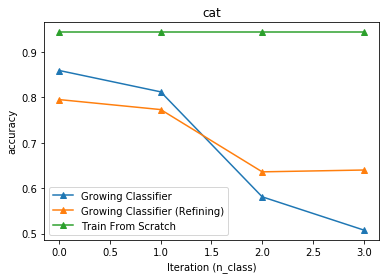

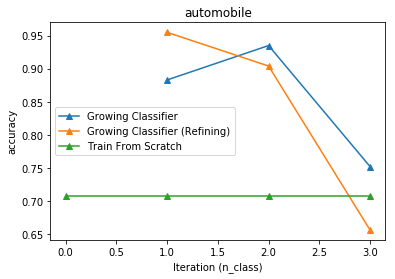

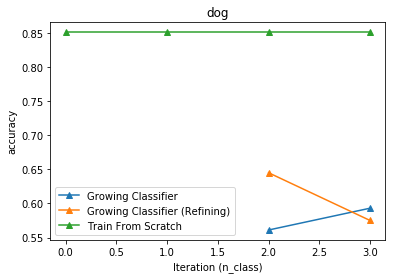

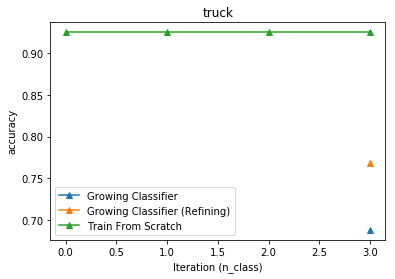

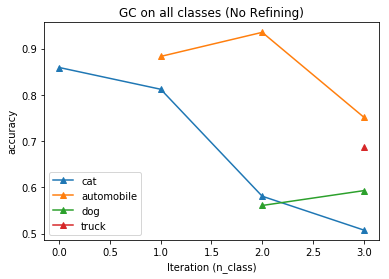

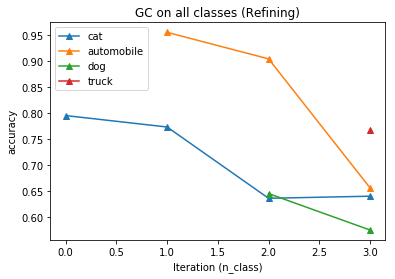

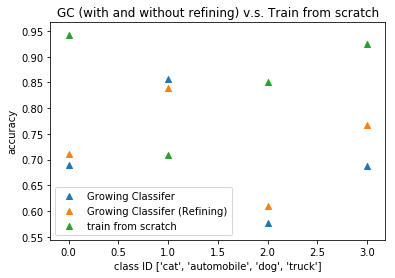

sequence of class addition: ['cat', 'automobile', 'truck', 'dog']

=====Training Using Growing Classifier (new classes appeared in 'Other' class before) ======

current other class: [ 1  2  3  5  6  7  8  9 10]
current target class: (4,)
all target target class: (4, 2, 10, 6)
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 45000
-----Fine Tuning------
Epoch 00010: early stopping
GC (refining) accuracy on sequence ['cat']: [0.7910000026226044]


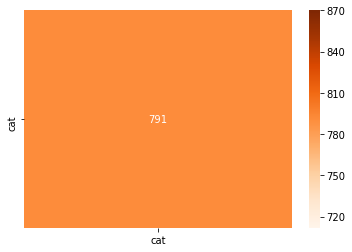

-----Adding a new class automobile (total classes including other: 3)------
current other class: [ 1  3  5  6  7  8  9 10]
current target class: (4, 2)
all target target class: (4, 2, 10, 6)
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 40000
-----Fine Tuning------
GC (refining) accuracy on sequence ['cat', 'automobile']: [0.7400000035762787, 0.9130000054836274]


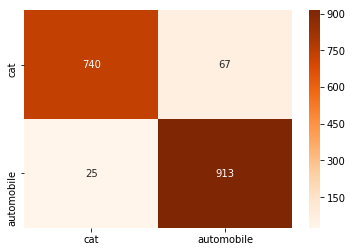

-----Adding a new class truck (total classes including other: 4)------
current other class: [1 3 5 6 7 8 9]
current target class: (4, 2, 10)
all target target class: (4, 2, 10, 6)
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 35000
-----Fine Tuning------
Epoch 00008: early stopping
GC (refining) accuracy on sequence ['cat', 'automobile', 'truck']: [0.6950000047683715, 0.7180000007152557, 0.6720000028610229]


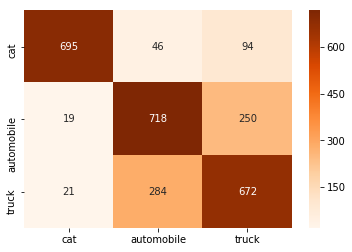

-----Adding a new class dog (total classes including other: 5)------
current other class: [1 3 5 7 8 9]
current target class: (4, 2, 10, 6)
all target target class: (4, 2, 10, 6)
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 30000
-----Fine Tuning------
GC (refining) accuracy on sequence ['cat', 'automobile', 'truck', 'dog']: [0.5540000021457672, 0.6289999961853028, 0.7580000042915345, 0.6379999995231629]


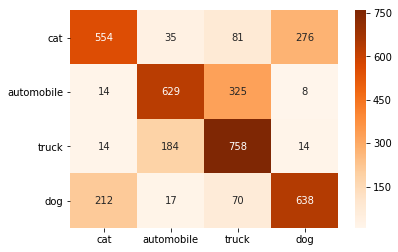


=====Training Using Growing Classifier (new classes never appeared in 'Other' class before) ======

current other class: [1 3 5 7 8 9]
current target class: (4,)
all target target class: (4, 2, 10, 6)
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 30000
-----Fine Tuning------
Epoch 00009: early stopping
GC (without refining) accuracy on sequence ['cat']: [0.8750000059604645]


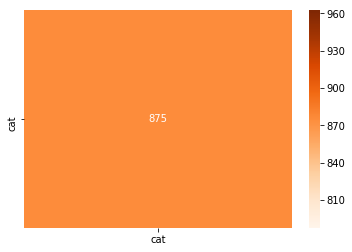

-----Adding a new class automobile (total classes including other: 3)------
current other class: [1 3 5 7 8 9]
current target class: (4, 2)
all target target class: (4, 2, 10, 6)
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 30000
-----Fine Tuning------
Epoch 00008: early stopping
GC (without refining) accuracy on sequence ['cat', 'automobile']: [0.8180000007152557, 0.875]


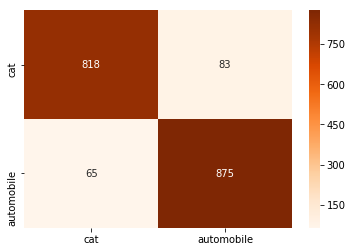

-----Adding a new class truck (total classes including other: 4)------
current other class: [1 3 5 7 8 9]
current target class: (4, 2, 10)
all target target class: (4, 2, 10, 6)
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 30000
-----Fine Tuning------
GC (without refining) accuracy on sequence ['cat', 'automobile', 'truck']: [0.6720000088214875, 0.7959999978542328, 0.5160000026226044]


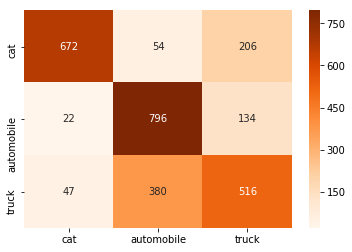

-----Adding a new class dog (total classes including other: 5)------
current other class: [1 3 5 7 8 9]
current target class: (4, 2, 10, 6)
all target target class: (4, 2, 10, 6)
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 30000
-----Fine Tuning------
GC (without refining) accuracy on sequence ['cat', 'automobile', 'truck', 'dog']: [0.514999994635582, 0.7680000007152558, 0.6089999973773956, 0.4499999970197678]


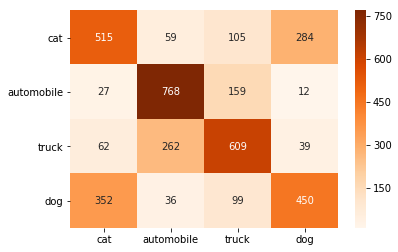

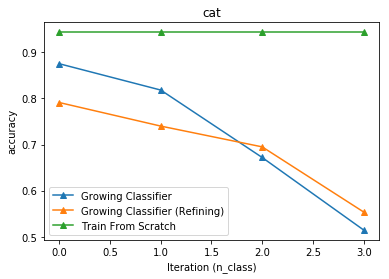

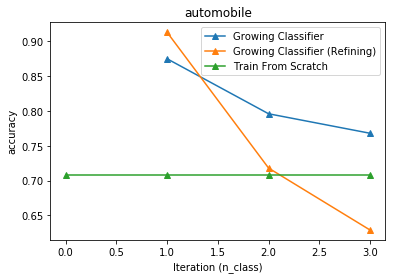

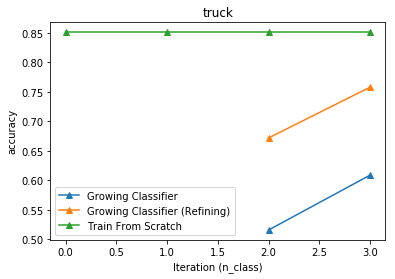

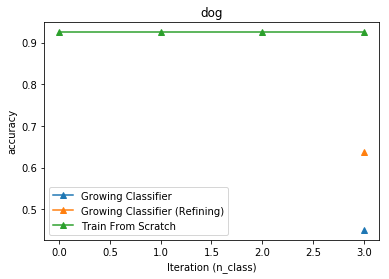

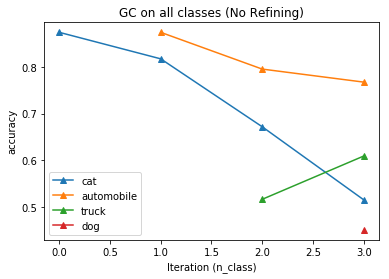

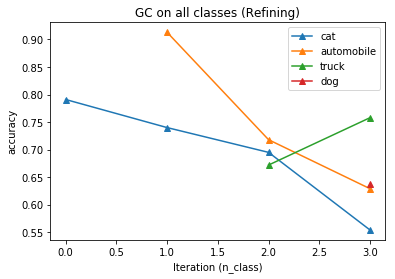

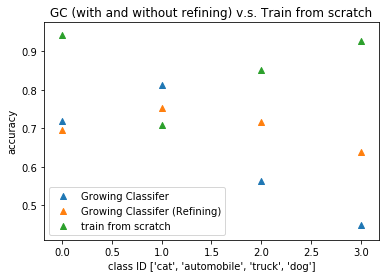

sequence of class addition: ['cat', 'dog', 'automobile', 'truck']

=====Training Using Growing Classifier (new classes appeared in 'Other' class before) ======

current other class: [ 1  2  3  5  6  7  8  9 10]
current target class: (4,)
all target target class: (4, 6, 2, 10)
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 45000
-----Fine Tuning------
GC (refining) accuracy on sequence ['cat']: [0.7619999885559082]


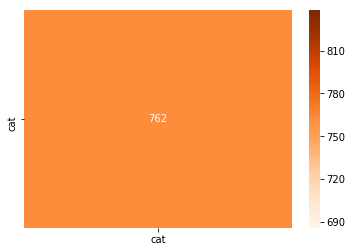

-----Adding a new class dog (total classes including other: 3)------
current other class: [ 1  2  3  5  7  8  9 10]
current target class: (4, 6)
all target target class: (4, 6, 2, 10)
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 40000
-----Fine Tuning------
Epoch 00008: early stopping
GC (refining) accuracy on sequence ['cat', 'dog']: [0.6799999952316285, 0.6609999895095825]


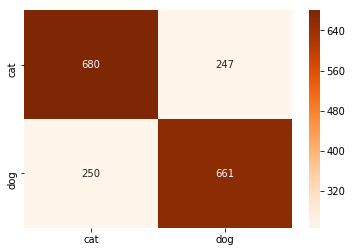

-----Adding a new class automobile (total classes including other: 4)------
current other class: [ 1  3  5  7  8  9 10]
current target class: (4, 6, 2)
all target target class: (4, 6, 2, 10)
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 35000
-----Fine Tuning------
GC (refining) accuracy on sequence ['cat', 'dog', 'automobile']: [0.664000004529953, 0.6370000004768371, 0.9219999969005584]


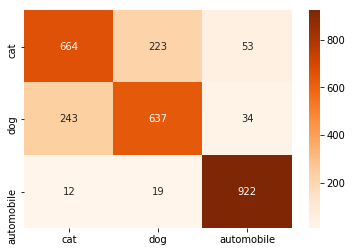

-----Adding a new class truck (total classes including other: 5)------
current other class: [1 3 5 7 8 9]
current target class: (4, 6, 2, 10)
all target target class: (4, 6, 2, 10)
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 30000
-----Fine Tuning------
GC (refining) accuracy on sequence ['cat', 'dog', 'automobile', 'truck']: [0.6509999930858612, 0.5819999992847442, 0.7729999959468842, 0.6119999945163727]


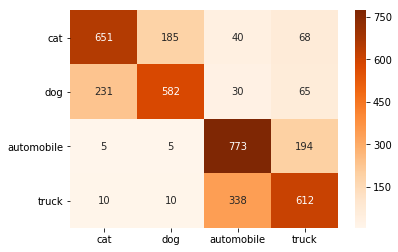


=====Training Using Growing Classifier (new classes never appeared in 'Other' class before) ======

current other class: [1 3 5 7 8 9]
current target class: (4,)
all target target class: (4, 6, 2, 10)
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 30000
-----Fine Tuning------
Epoch 00006: early stopping
GC (without refining) accuracy on sequence ['cat']: [0.8949999988079071]


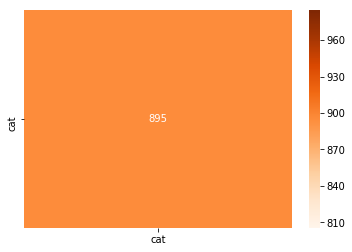

-----Adding a new class dog (total classes including other: 3)------
current other class: [1 3 5 7 8 9]
current target class: (4, 6)
all target target class: (4, 6, 2, 10)
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 30000
-----Fine Tuning------
GC (without refining) accuracy on sequence ['cat', 'dog']: [0.6760000050067901, 0.4770000040531158]


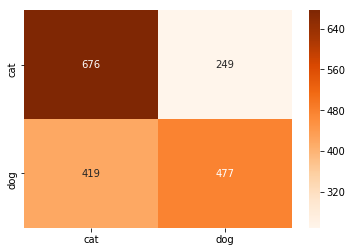

-----Adding a new class automobile (total classes including other: 4)------
current other class: [1 3 5 7 8 9]
current target class: (4, 6, 2)
all target target class: (4, 6, 2, 10)
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 30000
-----Fine Tuning------
GC (without refining) accuracy on sequence ['cat', 'dog', 'automobile']: [0.6069999992847442, 0.5219999969005584, 0.8689999938011169]


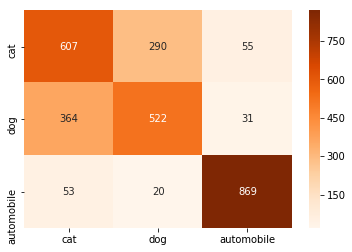

-----Adding a new class truck (total classes including other: 5)------
current other class: [1 3 5 7 8 9]
current target class: (4, 6, 2, 10)
all target target class: (4, 6, 2, 10)
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 30000
-----Fine Tuning------
Epoch 00006: early stopping
GC (without refining) accuracy on sequence ['cat', 'dog', 'automobile', 'truck']: [0.49699999690055846, 0.5599999964237213, 0.7399999916553497, 0.5139999955892562]


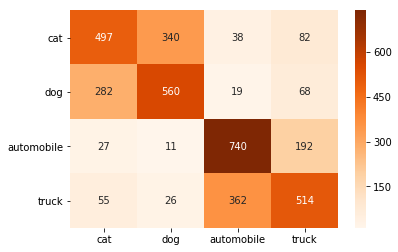

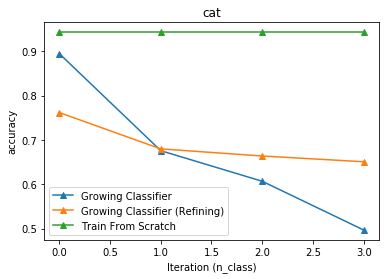

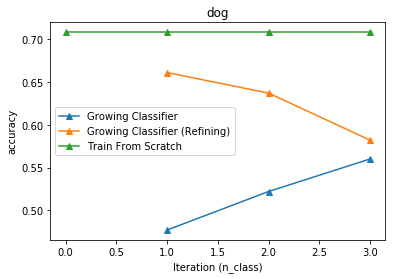

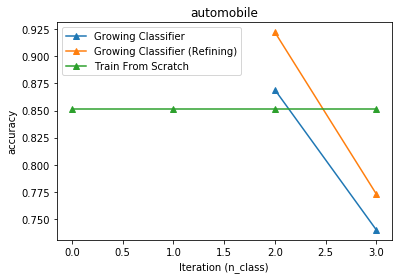

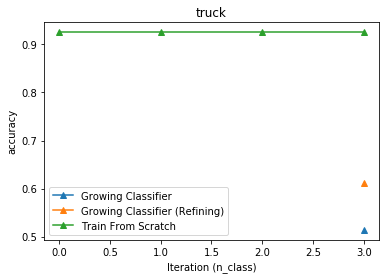

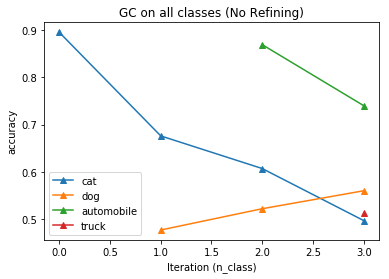

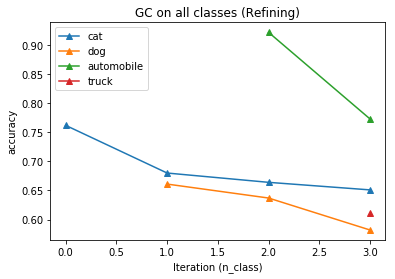

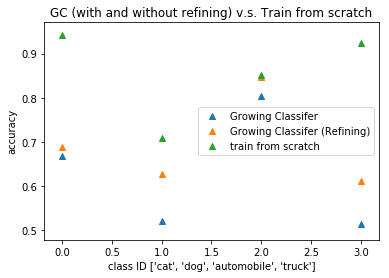

sequence of class addition: ['cat', 'dog', 'truck', 'automobile']

=====Training Using Growing Classifier (new classes appeared in 'Other' class before) ======

current other class: [ 1  2  3  5  6  7  8  9 10]
current target class: (4,)
all target target class: (4, 6, 10, 2)
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 45000
-----Fine Tuning------
Epoch 00009: early stopping
GC (refining) accuracy on sequence ['cat']: [0.8319999933242798]


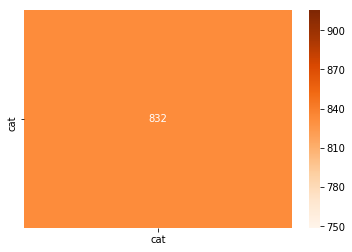

-----Adding a new class dog (total classes including other: 3)------
current other class: [ 1  2  3  5  7  8  9 10]
current target class: (4, 6)
all target target class: (4, 6, 10, 2)
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 40000
-----Fine Tuning------
GC (refining) accuracy on sequence ['cat', 'dog']: [0.6780000030994415, 0.6290000081062317]


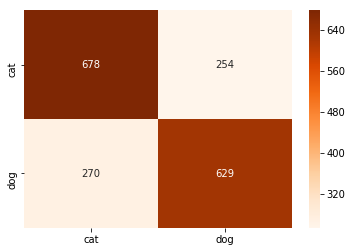

-----Adding a new class truck (total classes including other: 4)------
current other class: [1 2 3 5 7 8 9]
current target class: (4, 6, 10)
all target target class: (4, 6, 10, 2)
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 35000
-----Fine Tuning------
GC (refining) accuracy on sequence ['cat', 'dog', 'truck']: [0.6900000035762787, 0.6150000035762787, 0.8980000019073486]


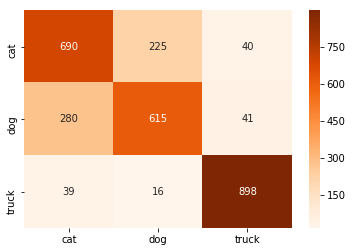

-----Adding a new class automobile (total classes including other: 5)------
current other class: [1 3 5 7 8 9]
current target class: (4, 6, 10, 2)
all target target class: (4, 6, 10, 2)
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 30000
-----Fine Tuning------
GC (refining) accuracy on sequence ['cat', 'dog', 'truck', 'automobile']: [0.6590000033378601, 0.5909999966621399, 0.5249999970197677, 0.8180000066757203]


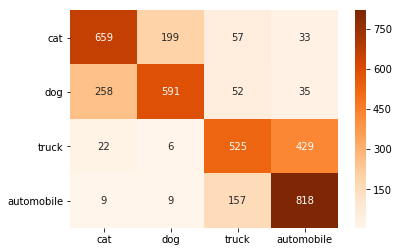


=====Training Using Growing Classifier (new classes never appeared in 'Other' class before) ======

current other class: [1 3 5 7 8 9]
current target class: (4,)
all target target class: (4, 6, 10, 2)
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 30000
-----Fine Tuning------
Epoch 00009: early stopping
GC (without refining) accuracy on sequence ['cat']: [0.8680000007152557]


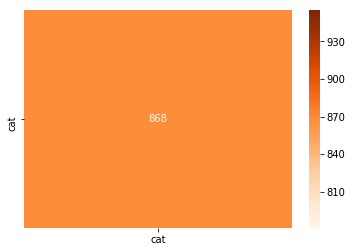

-----Adding a new class dog (total classes including other: 3)------
current other class: [1 3 5 7 8 9]
current target class: (4, 6)
all target target class: (4, 6, 10, 2)
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 30000
-----Fine Tuning------
Epoch 00008: early stopping
GC (without refining) accuracy on sequence ['cat', 'dog']: [0.6189999938011169, 0.5199999958276749]


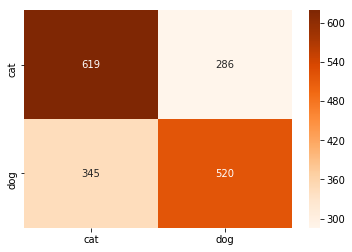

-----Adding a new class truck (total classes including other: 4)------
current other class: [1 3 5 7 8 9]
current target class: (4, 6, 10)
all target target class: (4, 6, 10, 2)
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 30000
-----Fine Tuning------
Epoch 00010: early stopping
GC (without refining) accuracy on sequence ['cat', 'dog', 'truck']: [0.6310000061988831, 0.49100000560283663, 0.8220000028610229]


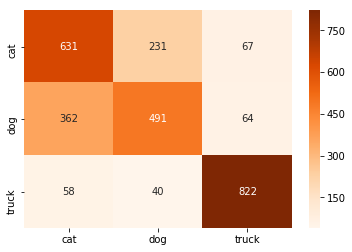

-----Adding a new class automobile (total classes including other: 5)------
current other class: [1 3 5 7 8 9]
current target class: (4, 6, 10, 2)
all target target class: (4, 6, 10, 2)
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 30000
-----Fine Tuning------
Epoch 00009: early stopping
GC (without refining) accuracy on sequence ['cat', 'dog', 'truck', 'automobile']: [0.6350000083446503, 0.4060000032186508, 0.6820000052452088, 0.6960000038146973]


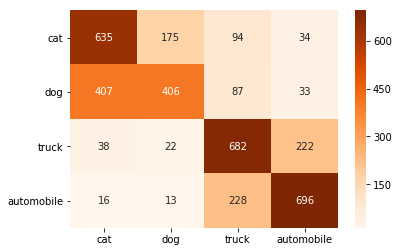

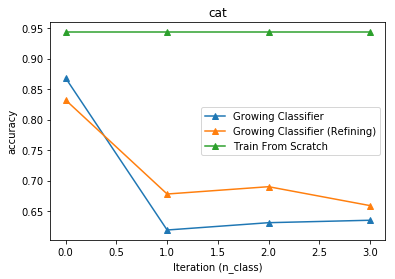

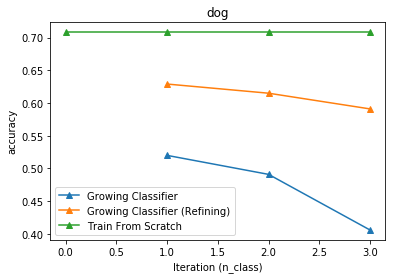

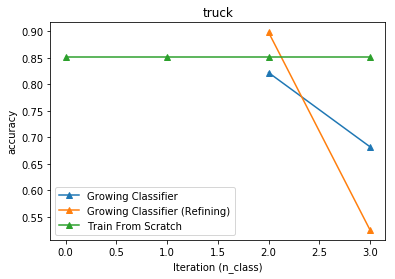

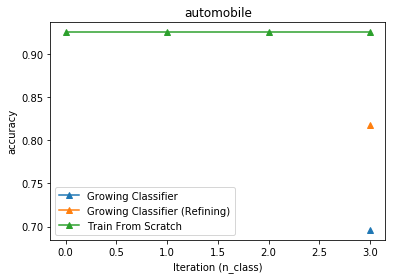

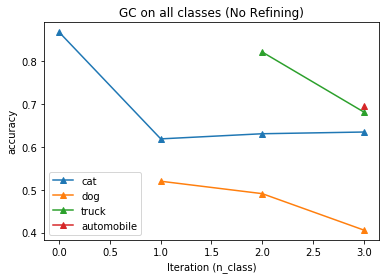

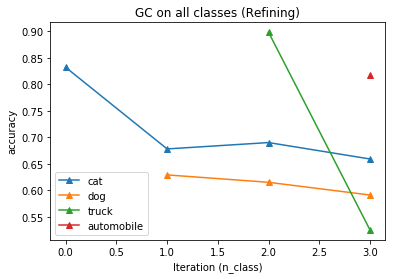

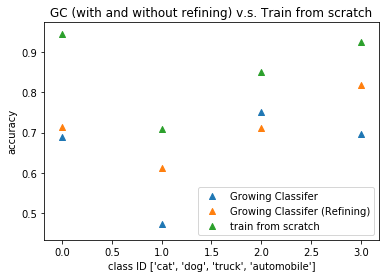

sequence of class addition: ['cat', 'truck', 'automobile', 'dog']

=====Training Using Growing Classifier (new classes appeared in 'Other' class before) ======

current other class: [ 1  2  3  5  6  7  8  9 10]
current target class: (4,)
all target target class: (4, 10, 2, 6)
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 45000
-----Fine Tuning------
Epoch 00007: early stopping
GC (refining) accuracy on sequence ['cat']: [0.8269999921321869]


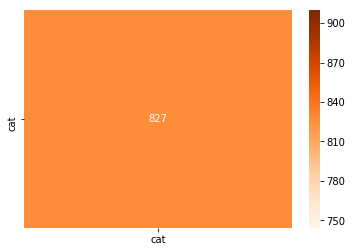

-----Adding a new class truck (total classes including other: 3)------
current other class: [1 2 3 5 6 7 8 9]
current target class: (4, 10)
all target target class: (4, 10, 2, 6)
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 40000
-----Fine Tuning------
Epoch 00006: early stopping
GC (refining) accuracy on sequence ['cat', 'truck']: [0.7759999990463257, 0.8069999992847443]


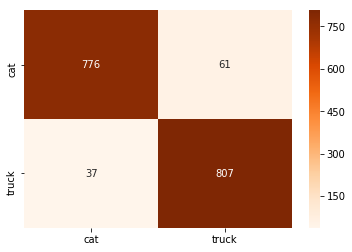

-----Adding a new class automobile (total classes including other: 4)------
current other class: [1 3 5 6 7 8 9]
current target class: (4, 10, 2)
all target target class: (4, 10, 2, 6)
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 35000
-----Fine Tuning------
GC (refining) accuracy on sequence ['cat', 'truck', 'automobile']: [0.7420000016689301, 0.4619999974966049, 0.8279999911785125]


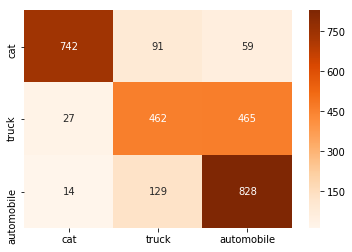

-----Adding a new class dog (total classes including other: 5)------
current other class: [1 3 5 7 8 9]
current target class: (4, 10, 2, 6)
all target target class: (4, 10, 2, 6)
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 30000
-----Fine Tuning------
GC (refining) accuracy on sequence ['cat', 'truck', 'automobile', 'dog']: [0.6020000040531158, 0.46699999272823334, 0.8299999952316284, 0.6290000021457672]


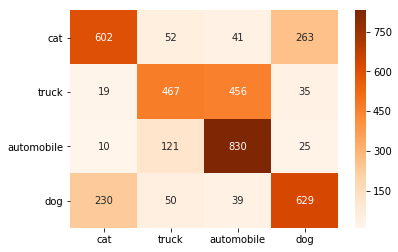


=====Training Using Growing Classifier (new classes never appeared in 'Other' class before) ======

current other class: [1 3 5 7 8 9]
current target class: (4,)
all target target class: (4, 10, 2, 6)
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 30000
-----Fine Tuning------
GC (without refining) accuracy on sequence ['cat']: [0.8240000009536743]


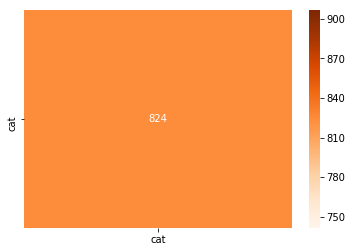

-----Adding a new class truck (total classes including other: 3)------
current other class: [1 3 5 7 8 9]
current target class: (4, 10)
all target target class: (4, 10, 2, 6)
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 30000
-----Fine Tuning------
Epoch 00008: early stopping
GC (without refining) accuracy on sequence ['cat', 'truck']: [0.7419999957084655, 0.81700000166893]


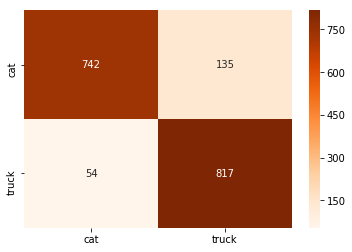

-----Adding a new class automobile (total classes including other: 4)------
current other class: [1 3 5 7 8 9]
current target class: (4, 10, 2)
all target target class: (4, 10, 2, 6)
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 30000
-----Fine Tuning------
Epoch 00008: early stopping
GC (without refining) accuracy on sequence ['cat', 'truck', 'automobile']: [0.6759999990463257, 0.622000002861023, 0.7899999976158142]


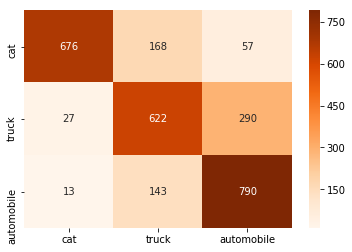

-----Adding a new class dog (total classes including other: 5)------
current other class: [1 3 5 7 8 9]
current target class: (4, 10, 2, 6)
all target target class: (4, 10, 2, 6)
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 30000
-----Fine Tuning------
Epoch 00006: early stopping
GC (without refining) accuracy on sequence ['cat', 'truck', 'automobile', 'dog']: [0.6059999942779541, 0.591999989748001, 0.8339999973773956, 0.3399999991059303]


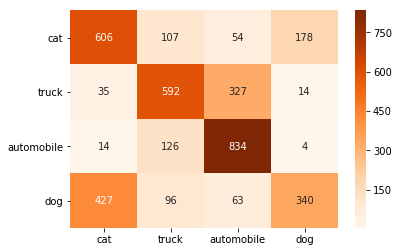

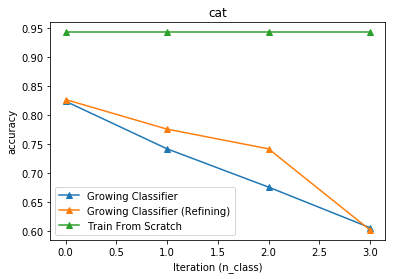

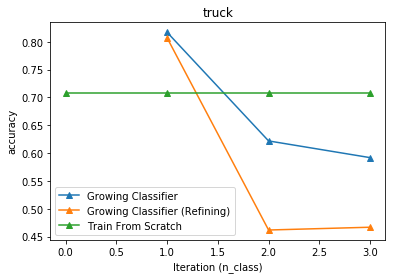

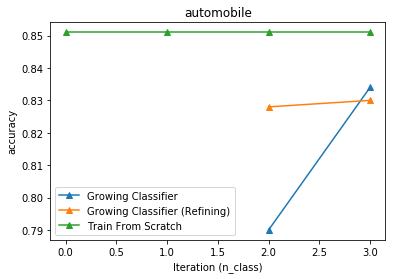

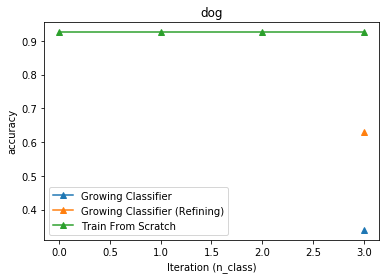

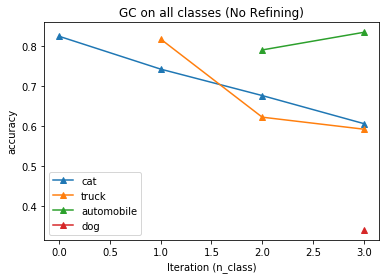

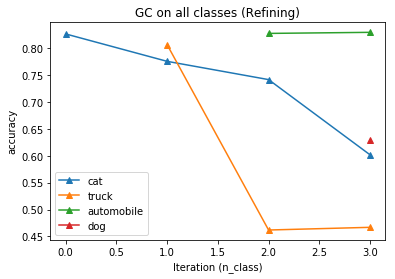

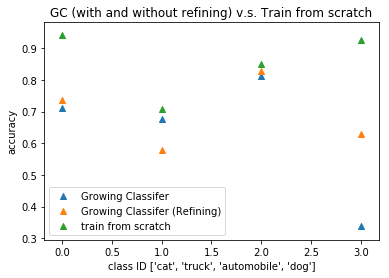

sequence of class addition: ['cat', 'truck', 'dog', 'automobile']

=====Training Using Growing Classifier (new classes appeared in 'Other' class before) ======

current other class: [ 1  2  3  5  6  7  8  9 10]
current target class: (4,)
all target target class: (4, 10, 6, 2)
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 45000
-----Fine Tuning------
Epoch 00009: early stopping
GC (refining) accuracy on sequence ['cat']: [0.8209999918937683]


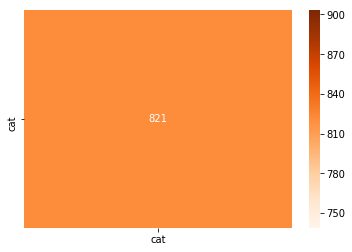

-----Adding a new class truck (total classes including other: 3)------
current other class: [1 2 3 5 6 7 8 9]
current target class: (4, 10)
all target target class: (4, 10, 6, 2)
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 40000
-----Fine Tuning------
Epoch 00006: early stopping
GC (refining) accuracy on sequence ['cat', 'truck']: [0.764000004529953, 0.8450000047683716]


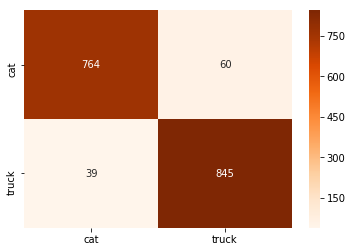

-----Adding a new class dog (total classes including other: 4)------
current other class: [1 2 3 5 7 8 9]
current target class: (4, 10, 6)
all target target class: (4, 10, 6, 2)
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 35000
-----Fine Tuning------
Epoch 00010: early stopping
GC (refining) accuracy on sequence ['cat', 'truck', 'dog']: [0.6550000011920929, 0.85799999833107, 0.5899999916553498]


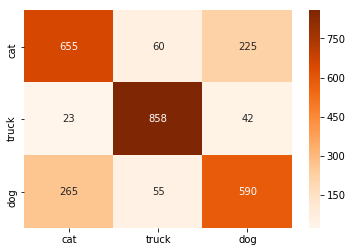

-----Adding a new class automobile (total classes including other: 5)------
current other class: [1 3 5 7 8 9]
current target class: (4, 10, 6, 2)
all target target class: (4, 10, 6, 2)
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 30000
-----Fine Tuning------
Epoch 00006: early stopping
GC (refining) accuracy on sequence ['cat', 'truck', 'dog', 'automobile']: [0.6429999947547913, 0.3490000069141388, 0.55, 0.8399999976158142]


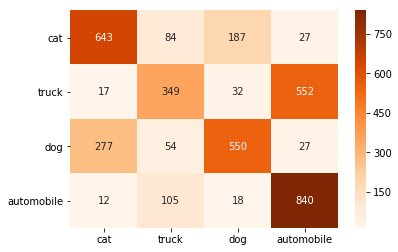


=====Training Using Growing Classifier (new classes never appeared in 'Other' class before) ======

current other class: [1 3 5 7 8 9]
current target class: (4,)
all target target class: (4, 10, 6, 2)
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 30000
-----Fine Tuning------
GC (without refining) accuracy on sequence ['cat']: [0.875]


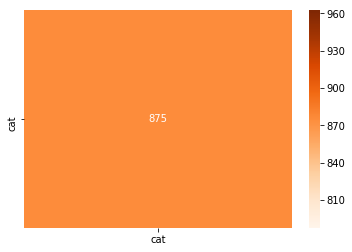

-----Adding a new class truck (total classes including other: 3)------
current other class: [1 3 5 7 8 9]
current target class: (4, 10)
all target target class: (4, 10, 6, 2)
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 30000
-----Fine Tuning------
Epoch 00010: early stopping
GC (without refining) accuracy on sequence ['cat', 'truck']: [0.8050000011920929, 0.560999995470047]


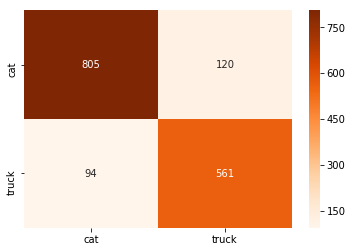

-----Adding a new class dog (total classes including other: 4)------
current other class: [1 3 5 7 8 9]
current target class: (4, 10, 6)
all target target class: (4, 10, 6, 2)
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 30000
-----Fine Tuning------
GC (without refining) accuracy on sequence ['cat', 'truck', 'dog']: [0.6230000019073486, 0.6959999978542328, 0.48599999248981474]


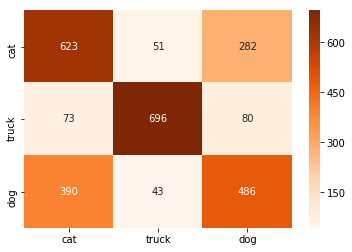

-----Adding a new class automobile (total classes including other: 5)------
current other class: [1 3 5 7 8 9]
current target class: (4, 10, 6, 2)
all target target class: (4, 10, 6, 2)
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 30000
-----Fine Tuning------
GC (without refining) accuracy on sequence ['cat', 'truck', 'dog', 'automobile']: [0.7010000050067902, 0.4809999972581863, 0.38399999737739565, 0.7010000050067902]


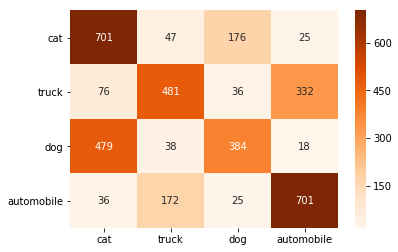

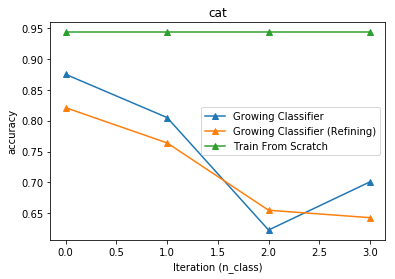

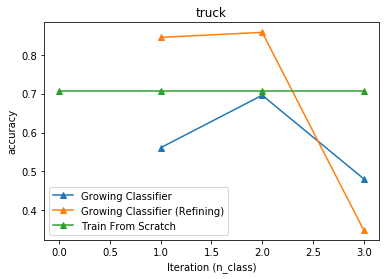

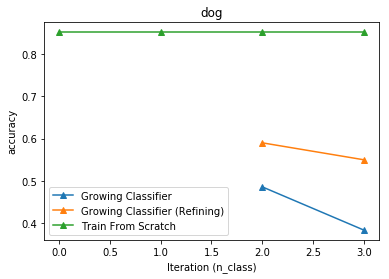

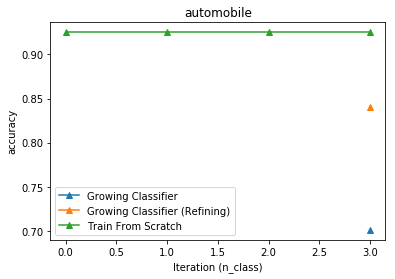

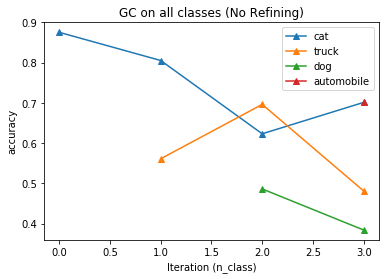

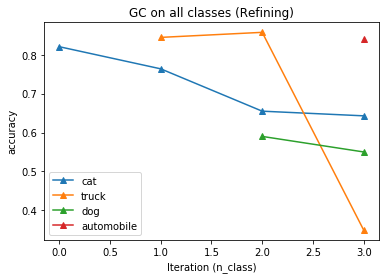

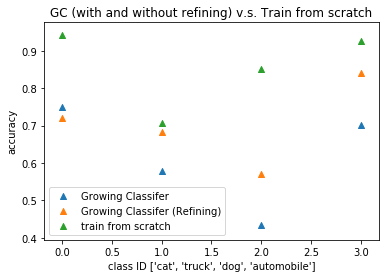

sequence of class addition: ['dog', 'automobile', 'cat', 'truck']

=====Training Using Growing Classifier (new classes appeared in 'Other' class before) ======

current other class: [ 1  2  3  4  5  7  8  9 10]
current target class: (6,)
all target target class: (6, 2, 4, 10)
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 45000
-----Fine Tuning------
Epoch 00007: early stopping
GC (refining) accuracy on sequence ['dog']: [0.9069999992847443]


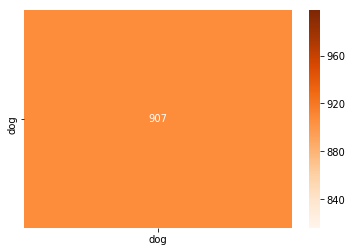

-----Adding a new class automobile (total classes including other: 3)------
current other class: [ 1  3  4  5  7  8  9 10]
current target class: (6, 2)
all target target class: (6, 2, 4, 10)
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 40000
-----Fine Tuning------
Epoch 00010: early stopping
GC (refining) accuracy on sequence ['dog', 'automobile']: [0.871999990940094, 0.9210000038146973]


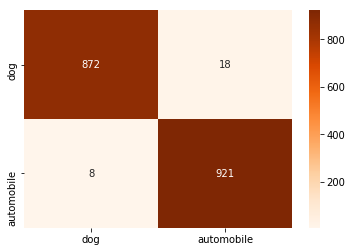

-----Adding a new class cat (total classes including other: 4)------
current other class: [ 1  3  5  7  8  9 10]
current target class: (6, 2, 4)
all target target class: (6, 2, 4, 10)
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 35000
-----Fine Tuning------
GC (refining) accuracy on sequence ['dog', 'automobile', 'cat']: [0.7899999916553497, 0.9509999990463257, 0.58299999833107]


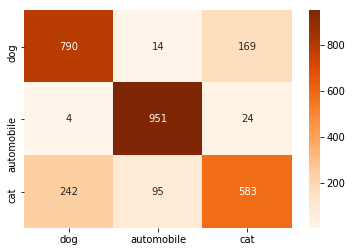

-----Adding a new class truck (total classes including other: 5)------
current other class: [1 3 5 7 8 9]
current target class: (6, 2, 4, 10)
all target target class: (6, 2, 4, 10)
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 30000
-----Fine Tuning------
Epoch 00006: early stopping
GC (refining) accuracy on sequence ['dog', 'automobile', 'cat', 'truck']: [0.8019999861717224, 0.7800000011920929, 0.4829999953508377, 0.6059999883174896]


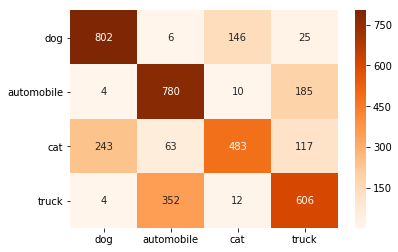


=====Training Using Growing Classifier (new classes never appeared in 'Other' class before) ======

current other class: [1 3 5 7 8 9]
current target class: (6,)
all target target class: (6, 2, 4, 10)
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 30000
-----Fine Tuning------
Epoch 00009: early stopping
GC (without refining) accuracy on sequence ['dog']: [0.9149999976158142]


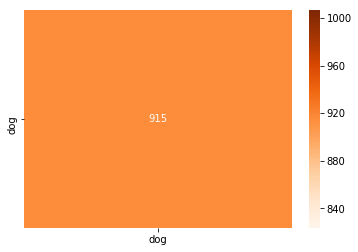

-----Adding a new class automobile (total classes including other: 3)------
current other class: [1 3 5 7 8 9]
current target class: (6, 2)
all target target class: (6, 2, 4, 10)
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 30000
-----Fine Tuning------
GC (without refining) accuracy on sequence ['dog', 'automobile']: [0.8490000009536743, 0.8809999942779541]


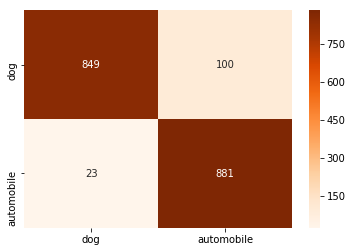

-----Adding a new class cat (total classes including other: 4)------
current other class: [1 3 5 7 8 9]
current target class: (6, 2, 4)
all target target class: (6, 2, 4, 10)
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 30000
-----Fine Tuning------
GC (without refining) accuracy on sequence ['dog', 'automobile', 'cat']: [0.7129999995231628, 0.9140000104904175, 0.4919999897480011]


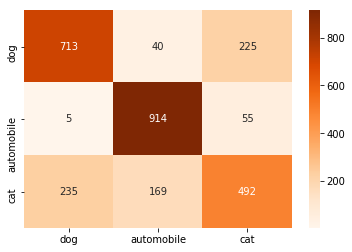

-----Adding a new class truck (total classes including other: 5)------
current other class: [1 3 5 7 8 9]
current target class: (6, 2, 4, 10)
all target target class: (6, 2, 4, 10)
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 30000
-----Fine Tuning------
Epoch 00006: early stopping
GC (without refining) accuracy on sequence ['dog', 'automobile', 'cat', 'truck']: [0.6680000007152558, 0.6340000033378601, 0.41099999845027924, 0.6949999928474426]


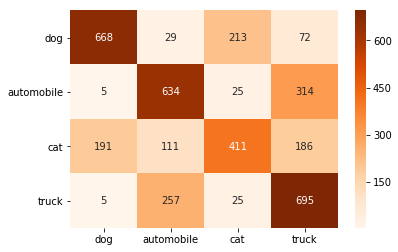

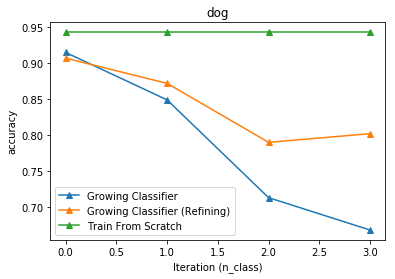

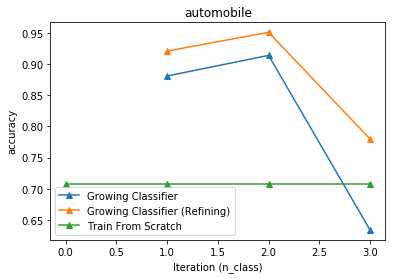

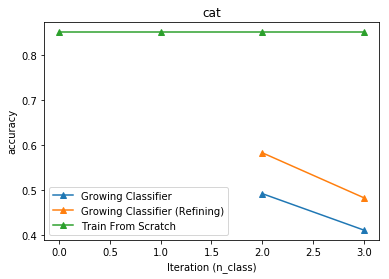

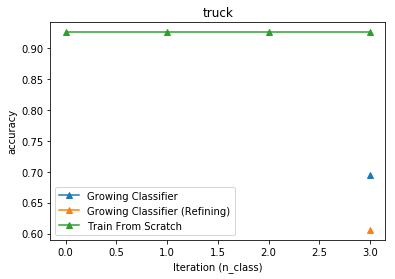

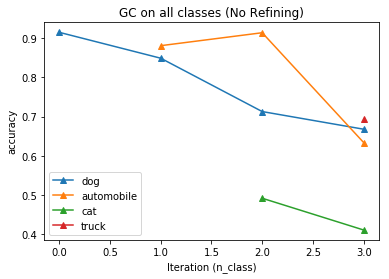

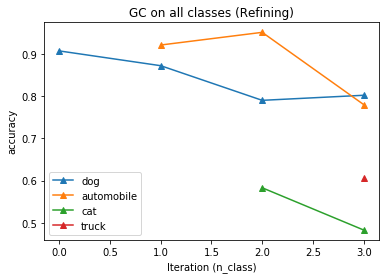

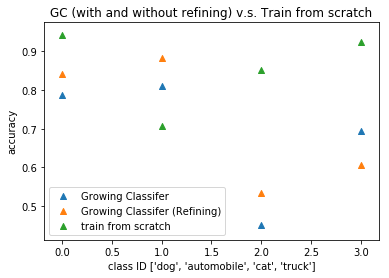

sequence of class addition: ['dog', 'automobile', 'truck', 'cat']

=====Training Using Growing Classifier (new classes appeared in 'Other' class before) ======

current other class: [ 1  2  3  4  5  7  8  9 10]
current target class: (6,)
all target target class: (6, 2, 10, 4)
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 45000
-----Fine Tuning------
GC (refining) accuracy on sequence ['dog']: [0.9269999980926513]


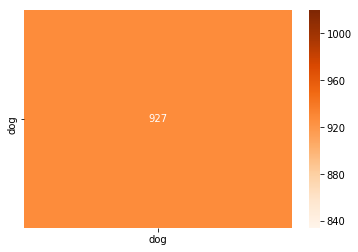

-----Adding a new class automobile (total classes including other: 3)------
current other class: [ 1  3  4  5  7  8  9 10]
current target class: (6, 2)
all target target class: (6, 2, 10, 4)
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 40000
-----Fine Tuning------
Epoch 00007: early stopping
GC (refining) accuracy on sequence ['dog', 'automobile']: [0.8399999916553498, 0.9310000002384186]


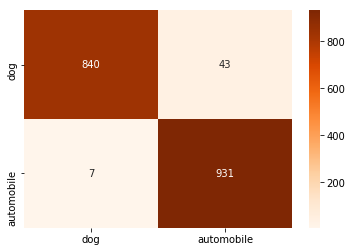

-----Adding a new class truck (total classes including other: 4)------
current other class: [1 3 4 5 7 8 9]
current target class: (6, 2, 10)
all target target class: (6, 2, 10, 4)
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 35000
-----Fine Tuning------
GC (refining) accuracy on sequence ['dog', 'automobile', 'truck']: [0.814000004529953, 0.6870000004768372, 0.6759999990463257]


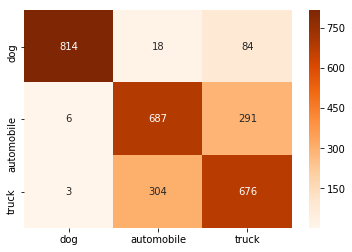

-----Adding a new class cat (total classes including other: 5)------
current other class: [1 3 5 7 8 9]
current target class: (6, 2, 10, 4)
all target target class: (6, 2, 10, 4)
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 30000
-----Fine Tuning------
GC (refining) accuracy on sequence ['dog', 'automobile', 'truck', 'cat']: [0.6879999995231628, 0.6600000023841858, 0.6869999945163727, 0.6260000050067902]


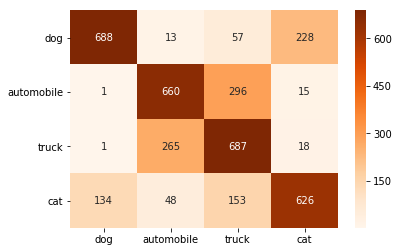


=====Training Using Growing Classifier (new classes never appeared in 'Other' class before) ======

current other class: [1 3 5 7 8 9]
current target class: (6,)
all target target class: (6, 2, 10, 4)
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 30000
-----Fine Tuning------
Epoch 00008: early stopping
GC (without refining) accuracy on sequence ['dog']: [0.8840000033378601]


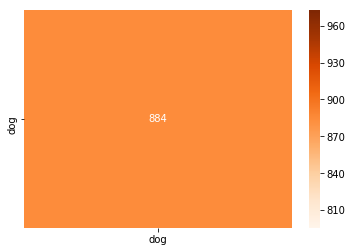

-----Adding a new class automobile (total classes including other: 3)------
current other class: [1 3 5 7 8 9]
current target class: (6, 2)
all target target class: (6, 2, 10, 4)
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 30000
-----Fine Tuning------
Epoch 00007: early stopping
GC (without refining) accuracy on sequence ['dog', 'automobile']: [0.8290000021457672, 0.8889999926090241]


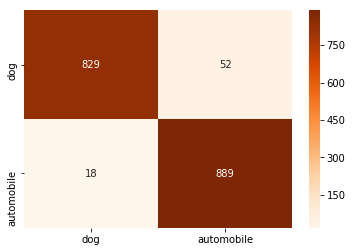

-----Adding a new class truck (total classes including other: 4)------
current other class: [1 3 5 7 8 9]
current target class: (6, 2, 10)
all target target class: (6, 2, 10, 4)
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 30000
-----Fine Tuning------
Epoch 00006: early stopping
GC (without refining) accuracy on sequence ['dog', 'automobile', 'truck']: [0.7579999983310699, 0.4869999885559082, 0.8129999935626984]


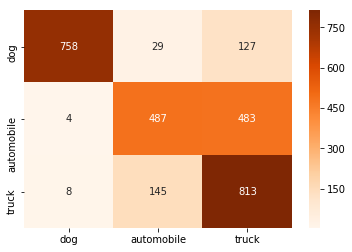

-----Adding a new class cat (total classes including other: 5)------
current other class: [1 3 5 7 8 9]
current target class: (6, 2, 10, 4)
all target target class: (6, 2, 10, 4)
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 30000
-----Fine Tuning------
Epoch 00007: early stopping
GC (without refining) accuracy on sequence ['dog', 'automobile', 'truck', 'cat']: [0.6159999966621399, 0.7179999947547913, 0.6079999923706054, 0.43400000035762787]


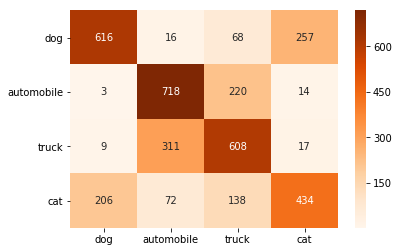

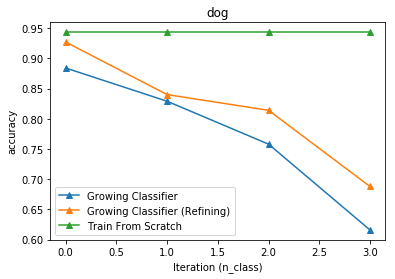

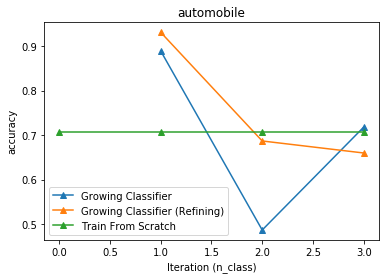

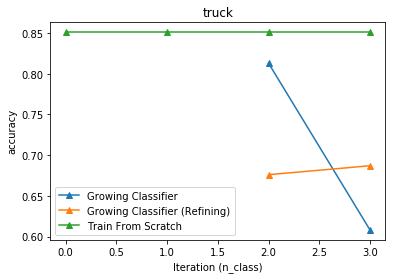

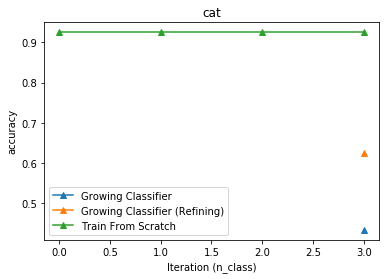

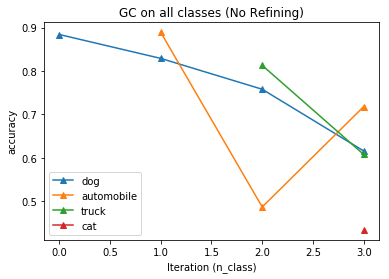

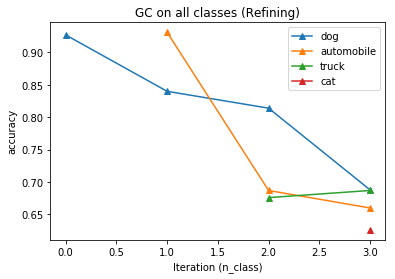

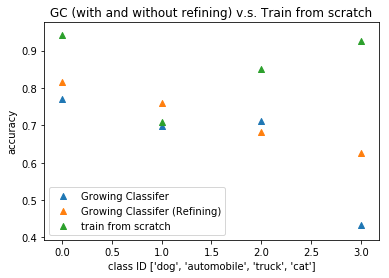

sequence of class addition: ['dog', 'cat', 'automobile', 'truck']

=====Training Using Growing Classifier (new classes appeared in 'Other' class before) ======

current other class: [ 1  2  3  4  5  7  8  9 10]
current target class: (6,)
all target target class: (6, 4, 2, 10)
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 45000
-----Fine Tuning------
Epoch 00008: early stopping
GC (refining) accuracy on sequence ['dog']: [0.889000004529953]


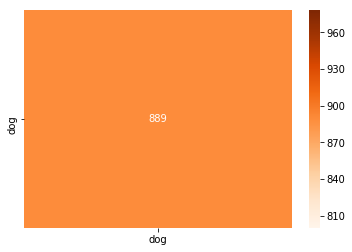

-----Adding a new class cat (total classes including other: 3)------
current other class: [ 1  2  3  5  7  8  9 10]
current target class: (6, 4)
all target target class: (6, 4, 2, 10)
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 40000
-----Fine Tuning------
GC (refining) accuracy on sequence ['dog', 'cat']: [0.6780000030994415, 0.7829999983310699]


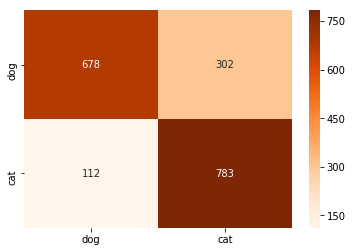

-----Adding a new class automobile (total classes including other: 4)------
current other class: [ 1  3  5  7  8  9 10]
current target class: (6, 4, 2)
all target target class: (6, 4, 2, 10)
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 35000
-----Fine Tuning------
GC (refining) accuracy on sequence ['dog', 'cat', 'automobile']: [0.681000006198883, 0.6689999997615814, 0.9520000040531158]


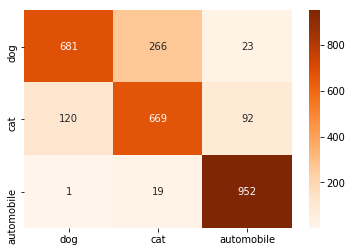

-----Adding a new class truck (total classes including other: 5)------
current other class: [1 3 5 7 8 9]
current target class: (6, 4, 2, 10)
all target target class: (6, 4, 2, 10)
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 30000
-----Fine Tuning------
Epoch 00006: early stopping
GC (refining) accuracy on sequence ['dog', 'cat', 'automobile', 'truck']: [0.6680000066757202, 0.6149999976158143, 0.8280000030994416, 0.4699999988079071]


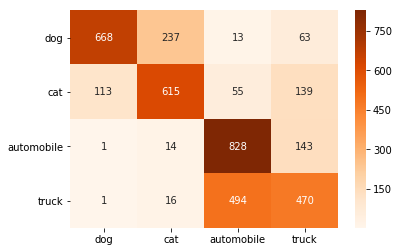


=====Training Using Growing Classifier (new classes never appeared in 'Other' class before) ======

current other class: [1 3 5 7 8 9]
current target class: (6,)
all target target class: (6, 4, 2, 10)
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 30000
-----Fine Tuning------
GC (without refining) accuracy on sequence ['dog']: [0.93299999833107]


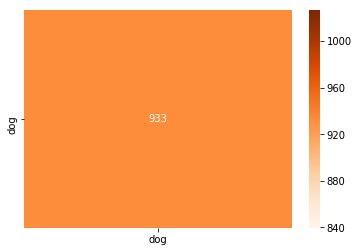

-----Adding a new class cat (total classes including other: 3)------
current other class: [1 3 5 7 8 9]
current target class: (6, 4)
all target target class: (6, 4, 2, 10)
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 30000
-----Fine Tuning------
Epoch 00007: early stopping
GC (without refining) accuracy on sequence ['dog', 'cat']: [0.7010000109672546, 0.5639999985694886]


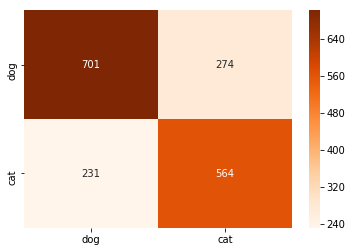

-----Adding a new class automobile (total classes including other: 4)------
current other class: [1 3 5 7 8 9]
current target class: (6, 4, 2)
all target target class: (6, 4, 2, 10)
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 30000
-----Fine Tuning------
Epoch 00008: early stopping
GC (without refining) accuracy on sequence ['dog', 'cat', 'automobile']: [0.6980000019073487, 0.5280000030994415, 0.7939999997615814]


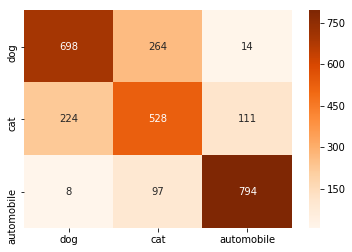

-----Adding a new class truck (total classes including other: 5)------
current other class: [1 3 5 7 8 9]
current target class: (6, 4, 2, 10)
all target target class: (6, 4, 2, 10)
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 30000
-----Fine Tuning------
GC (without refining) accuracy on sequence ['dog', 'cat', 'automobile', 'truck']: [0.7019999921321869, 0.4179999977350235, 0.5559999853372574, 0.6570000052452087]


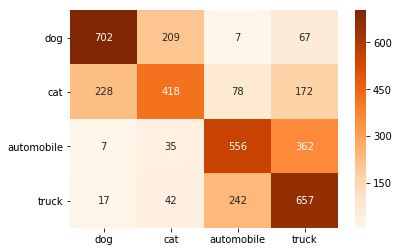

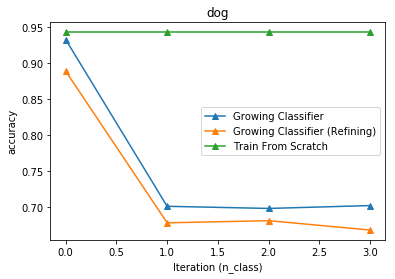

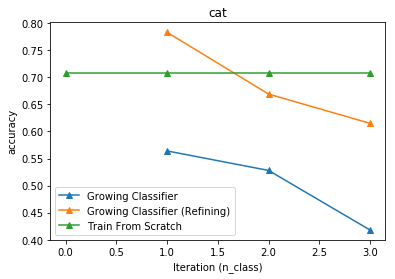

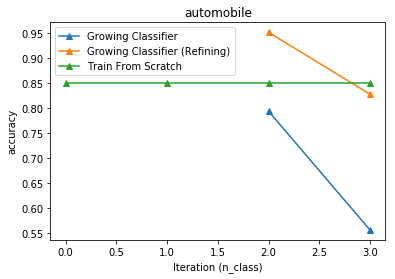

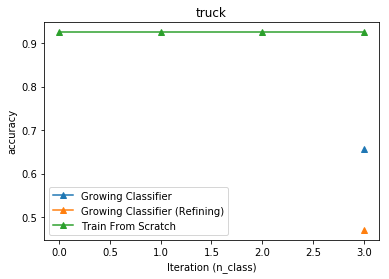

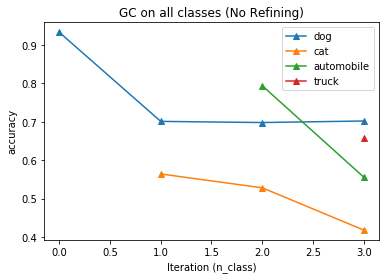

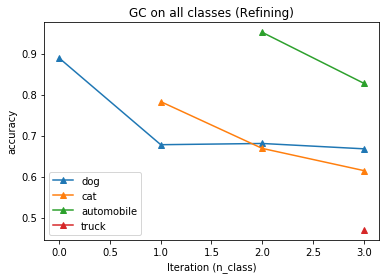

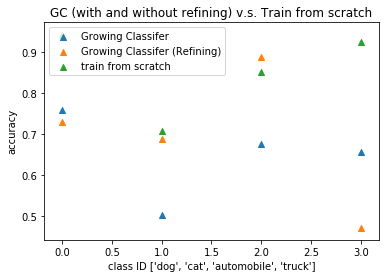

sequence of class addition: ['dog', 'cat', 'truck', 'automobile']

=====Training Using Growing Classifier (new classes appeared in 'Other' class before) ======

current other class: [ 1  2  3  4  5  7  8  9 10]
current target class: (6,)
all target target class: (6, 4, 10, 2)
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 45000
-----Fine Tuning------
GC (refining) accuracy on sequence ['dog']: [0.8819999992847443]


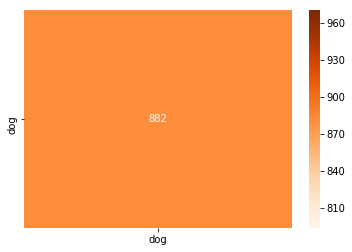

-----Adding a new class cat (total classes including other: 3)------
current other class: [ 1  2  3  5  7  8  9 10]
current target class: (6, 4)
all target target class: (6, 4, 10, 2)
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 40000
-----Fine Tuning------
Epoch 00009: early stopping
GC (refining) accuracy on sequence ['dog', 'cat']: [0.774999988079071, 0.6990000128746032]


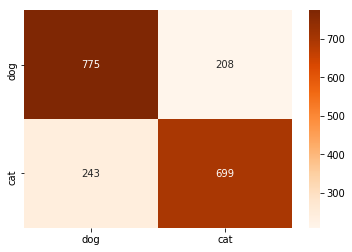

-----Adding a new class truck (total classes including other: 4)------
current other class: [1 2 3 5 7 8 9]
current target class: (6, 4, 10)
all target target class: (6, 4, 10, 2)
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 35000
-----Fine Tuning------
GC (refining) accuracy on sequence ['dog', 'cat', 'truck']: [0.7540000021457672, 0.6219999969005585, 0.8980000019073486]


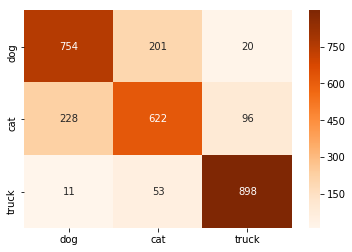

-----Adding a new class automobile (total classes including other: 5)------
current other class: [1 3 5 7 8 9]
current target class: (6, 4, 10, 2)
all target target class: (6, 4, 10, 2)
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 30000
-----Fine Tuning------
Epoch 00007: early stopping
GC (refining) accuracy on sequence ['dog', 'cat', 'truck', 'automobile']: [0.7390000104904175, 0.5719999969005585, 0.5419999957084656, 0.8480000019073486]


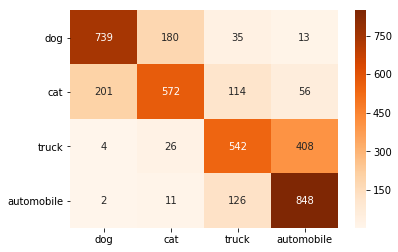


=====Training Using Growing Classifier (new classes never appeared in 'Other' class before) ======

current other class: [1 3 5 7 8 9]
current target class: (6,)
all target target class: (6, 4, 10, 2)
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 30000
-----Fine Tuning------
Epoch 00008: early stopping
GC (without refining) accuracy on sequence ['dog']: [0.8980000138282775]


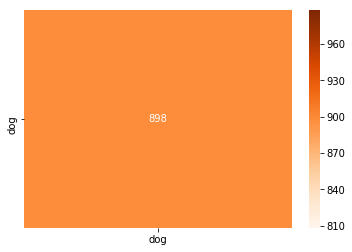

-----Adding a new class cat (total classes including other: 3)------
current other class: [1 3 5 7 8 9]
current target class: (6, 4)
all target target class: (6, 4, 10, 2)
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 30000
-----Fine Tuning------
Epoch 00008: early stopping
GC (without refining) accuracy on sequence ['dog', 'cat']: [0.70799999833107, 0.5620000004768372]


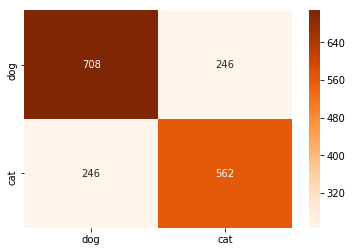

-----Adding a new class truck (total classes including other: 4)------
current other class: [1 3 5 7 8 9]
current target class: (6, 4, 10)
all target target class: (6, 4, 10, 2)
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 30000
-----Fine Tuning------
Epoch 00006: early stopping
GC (without refining) accuracy on sequence ['dog', 'cat', 'truck']: [0.7149999976158142, 0.4399999976158142, 0.8929999947547913]


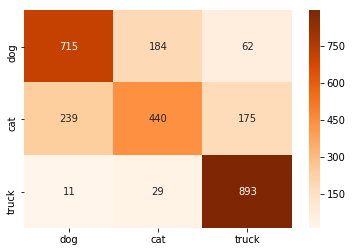

-----Adding a new class automobile (total classes including other: 5)------
current other class: [1 3 5 7 8 9]
current target class: (6, 4, 10, 2)
all target target class: (6, 4, 10, 2)
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 30000
-----Fine Tuning------
Epoch 00007: early stopping
GC (without refining) accuracy on sequence ['dog', 'cat', 'truck', 'automobile']: [0.6119999945163727, 0.41099999845027924, 0.48799999356269835, 0.8339999973773956]


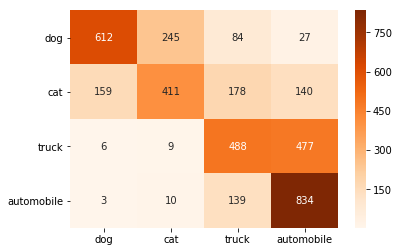

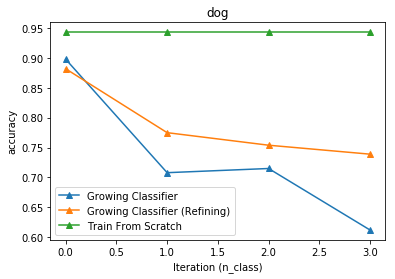

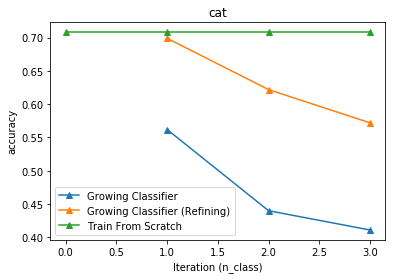

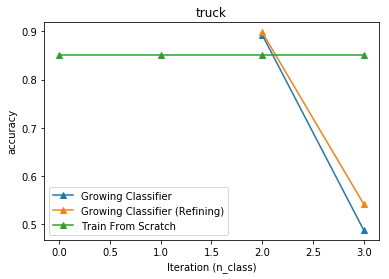

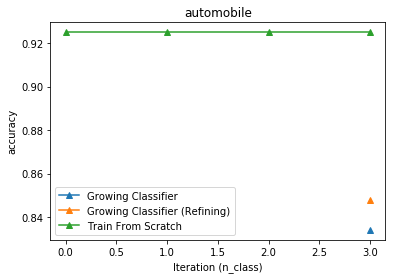

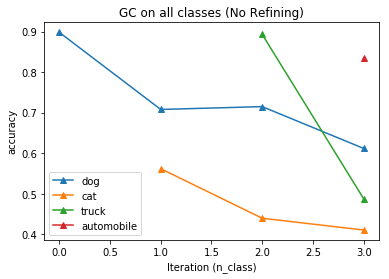

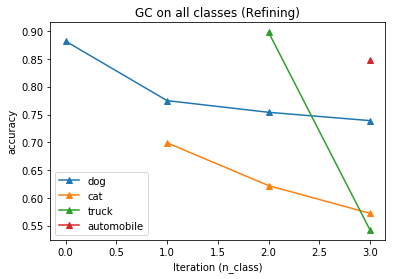

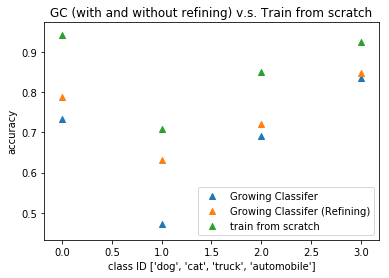

sequence of class addition: ['dog', 'truck', 'automobile', 'cat']

=====Training Using Growing Classifier (new classes appeared in 'Other' class before) ======

current other class: [ 1  2  3  4  5  7  8  9 10]
current target class: (6,)
all target target class: (6, 10, 2, 4)
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 45000
-----Fine Tuning------
GC (refining) accuracy on sequence ['dog']: [0.9090000033378601]


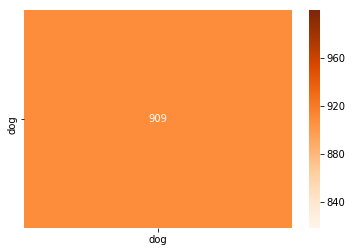

-----Adding a new class truck (total classes including other: 3)------
current other class: [1 2 3 4 5 7 8 9]
current target class: (6, 10)
all target target class: (6, 10, 2, 4)
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 40000
-----Fine Tuning------
Epoch 00007: early stopping
GC (refining) accuracy on sequence ['dog', 'truck']: [0.841999989748001, 0.8509999990463257]


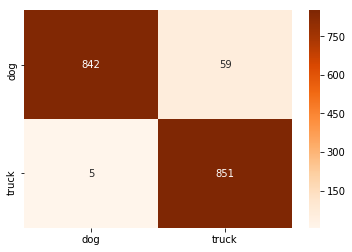

-----Adding a new class automobile (total classes including other: 4)------
current other class: [1 3 4 5 7 8 9]
current target class: (6, 10, 2)
all target target class: (6, 10, 2, 4)
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 35000
-----Fine Tuning------
Epoch 00006: early stopping
GC (refining) accuracy on sequence ['dog', 'truck', 'automobile']: [0.7789999961853027, 0.5750000029802322, 0.7429999947547913]


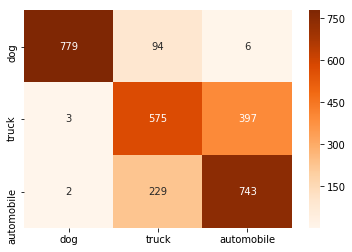

-----Adding a new class cat (total classes including other: 5)------
current other class: [1 3 5 7 8 9]
current target class: (6, 10, 2, 4)
all target target class: (6, 10, 2, 4)
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 30000
-----Fine Tuning------
GC (refining) accuracy on sequence ['dog', 'truck', 'automobile', 'cat']: [0.7419999957084655, 0.7469999849796295, 0.6109999984502792, 0.5399999916553497]


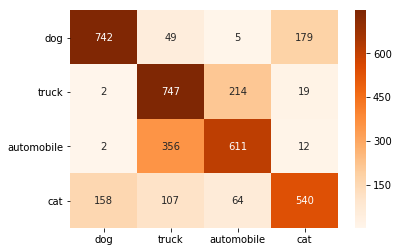


=====Training Using Growing Classifier (new classes never appeared in 'Other' class before) ======

current other class: [1 3 5 7 8 9]
current target class: (6,)
all target target class: (6, 10, 2, 4)
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 30000
-----Fine Tuning------
GC (without refining) accuracy on sequence ['dog']: [0.9050000011920929]


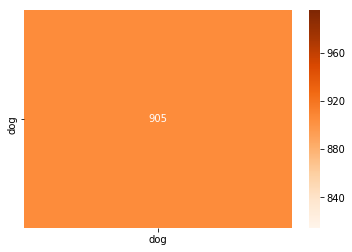

-----Adding a new class truck (total classes including other: 3)------
current other class: [1 3 5 7 8 9]
current target class: (6, 10)
all target target class: (6, 10, 2, 4)
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 30000
-----Fine Tuning------
GC (without refining) accuracy on sequence ['dog', 'truck']: [0.8420000076293945, 0.9500000059604645]


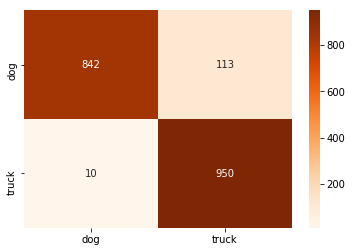

-----Adding a new class automobile (total classes including other: 4)------
current other class: [1 3 5 7 8 9]
current target class: (6, 10, 2)
all target target class: (6, 10, 2, 4)
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 30000
-----Fine Tuning------
Epoch 00008: early stopping
GC (without refining) accuracy on sequence ['dog', 'truck', 'automobile']: [0.8219999969005585, 0.6970000028610229, 0.6349999964237213]


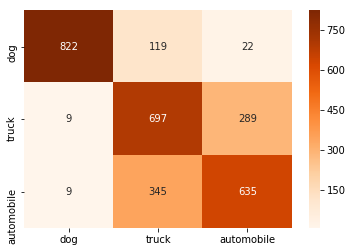

-----Adding a new class cat (total classes including other: 5)------
current other class: [1 3 5 7 8 9]
current target class: (6, 10, 2, 4)
all target target class: (6, 10, 2, 4)
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 30000
-----Fine Tuning------
GC (without refining) accuracy on sequence ['dog', 'truck', 'automobile', 'cat']: [0.7589999973773957, 0.722000002861023, 0.6170000076293946, 0.2790000006556511]


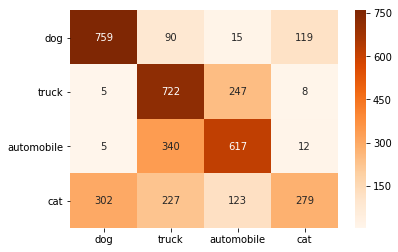

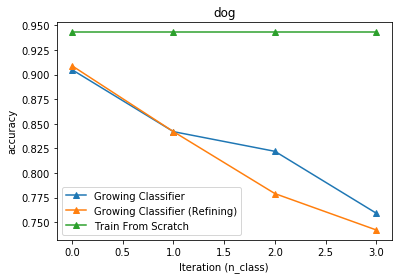

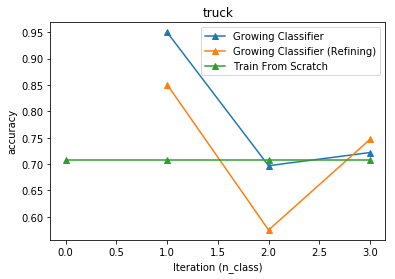

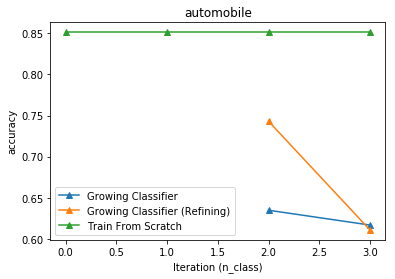

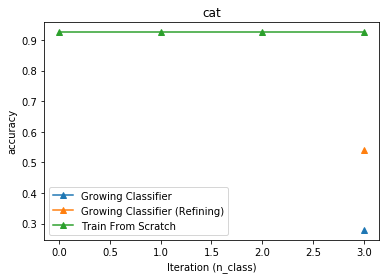

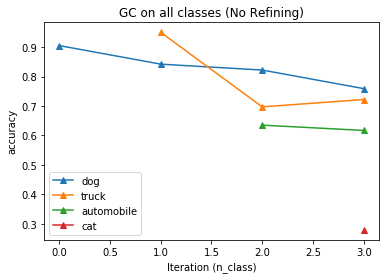

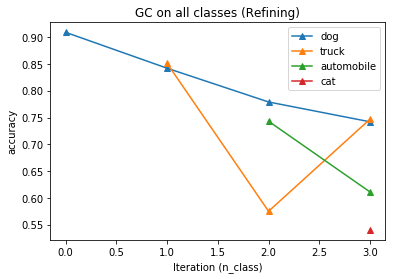

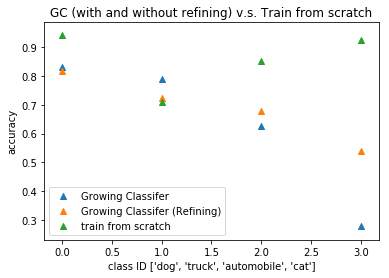

sequence of class addition: ['dog', 'truck', 'cat', 'automobile']

=====Training Using Growing Classifier (new classes appeared in 'Other' class before) ======

current other class: [ 1  2  3  4  5  7  8  9 10]
current target class: (6,)
all target target class: (6, 10, 4, 2)
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 45000
-----Fine Tuning------
Epoch 00007: early stopping
GC (refining) accuracy on sequence ['dog']: [0.8870000004768371]


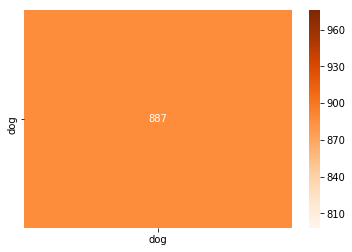

-----Adding a new class truck (total classes including other: 3)------
current other class: [1 2 3 4 5 7 8 9]
current target class: (6, 10)
all target target class: (6, 10, 4, 2)
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 40000
-----Fine Tuning------
Epoch 00006: early stopping
GC (refining) accuracy on sequence ['dog', 'truck']: [0.806000006198883, 0.9600000143051147]


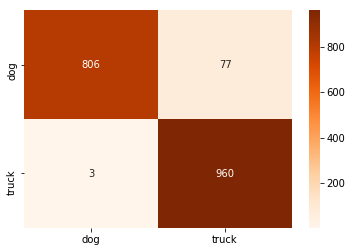

-----Adding a new class cat (total classes including other: 4)------
current other class: [1 2 3 5 7 8 9]
current target class: (6, 10, 4)
all target target class: (6, 10, 4, 2)
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 35000
-----Fine Tuning------
GC (refining) accuracy on sequence ['dog', 'truck', 'cat']: [0.7420000016689301, 0.9300000011920929, 0.5420000046491623]


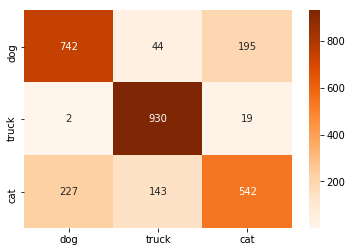

-----Adding a new class automobile (total classes including other: 5)------
current other class: [1 3 5 7 8 9]
current target class: (6, 10, 4, 2)
all target target class: (6, 10, 4, 2)
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 30000
-----Fine Tuning------
GC (refining) accuracy on sequence ['dog', 'truck', 'cat', 'automobile']: [0.710999995470047, 0.6120000064373017, 0.4960000067949295, 0.7930000007152558]


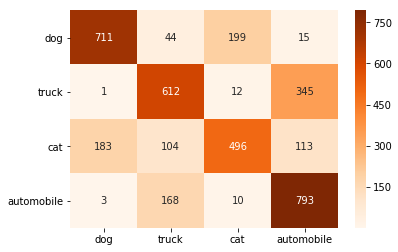


=====Training Using Growing Classifier (new classes never appeared in 'Other' class before) ======

current other class: [1 3 5 7 8 9]
current target class: (6,)
all target target class: (6, 10, 4, 2)
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 30000
-----Fine Tuning------
Epoch 00007: early stopping
GC (without refining) accuracy on sequence ['dog']: [0.8460000038146973]


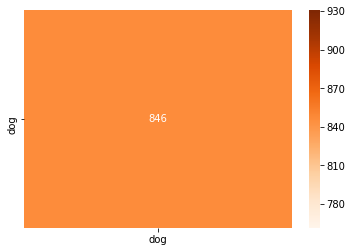

-----Adding a new class truck (total classes including other: 3)------
current other class: [1 3 5 7 8 9]
current target class: (6, 10)
all target target class: (6, 10, 4, 2)
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 30000
-----Fine Tuning------
Epoch 00010: early stopping
GC (without refining) accuracy on sequence ['dog', 'truck']: [0.7850000083446502, 0.8519999921321869]


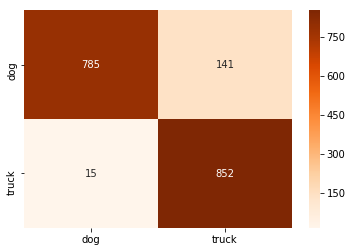

-----Adding a new class cat (total classes including other: 4)------
current other class: [1 3 5 7 8 9]
current target class: (6, 10, 4)
all target target class: (6, 10, 4, 2)
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 30000
-----Fine Tuning------
Epoch 00006: early stopping
GC (without refining) accuracy on sequence ['dog', 'truck', 'cat']: [0.675, 0.8539999842643737, 0.3759999990463257]


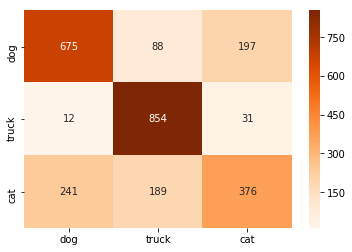

-----Adding a new class automobile (total classes including other: 5)------
current other class: [1 3 5 7 8 9]
current target class: (6, 10, 4, 2)
all target target class: (6, 10, 4, 2)
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 30000
-----Fine Tuning------
Epoch 00010: early stopping
GC (without refining) accuracy on sequence ['dog', 'truck', 'cat', 'automobile']: [0.6519999980926514, 0.5750000059604645, 0.3759999990463257, 0.722000002861023]


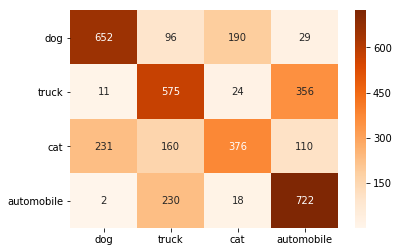

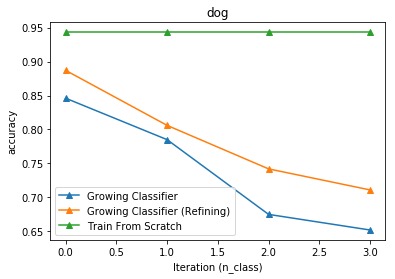

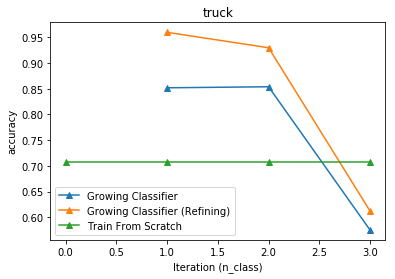

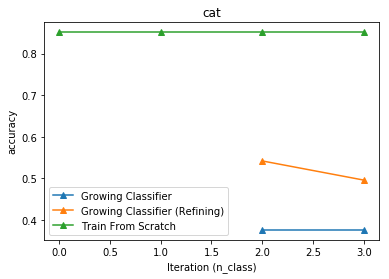

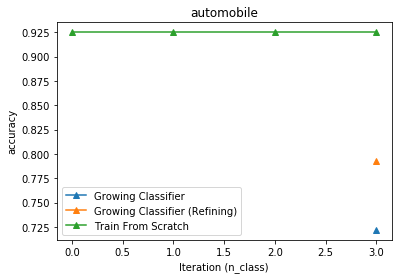

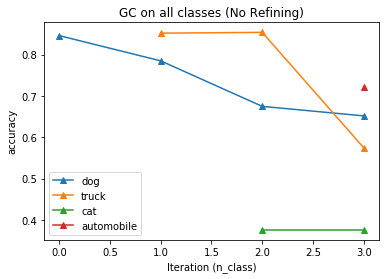

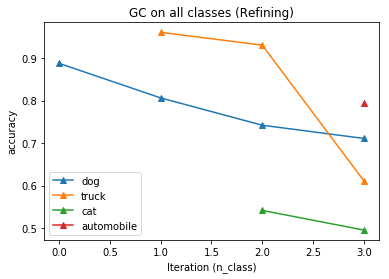

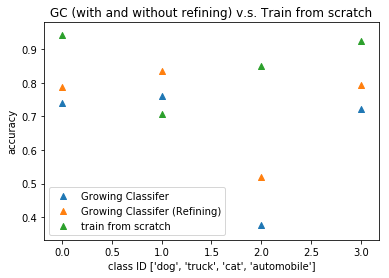

sequence of class addition: ['truck', 'automobile', 'cat', 'dog']

=====Training Using Growing Classifier (new classes appeared in 'Other' class before) ======

current other class: [1 2 3 4 5 6 7 8 9]
current target class: (10,)
all target target class: (10, 2, 4, 6)
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 45000
-----Fine Tuning------
Epoch 00010: early stopping
GC (refining) accuracy on sequence ['truck']: [0.9389999985694886]


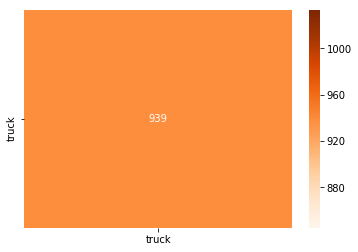

-----Adding a new class automobile (total classes including other: 3)------
current other class: [1 3 4 5 6 7 8 9]
current target class: (10, 2)
all target target class: (10, 2, 4, 6)
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 40000
-----Fine Tuning------
GC (refining) accuracy on sequence ['truck', 'automobile']: [0.8610000014305115, 0.9259999990463257]


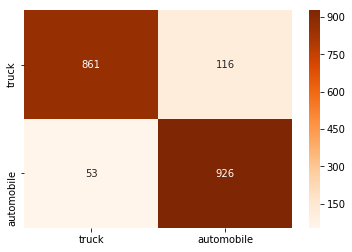

-----Adding a new class cat (total classes including other: 4)------
current other class: [1 3 5 6 7 8 9]
current target class: (10, 2, 4)
all target target class: (10, 2, 4, 6)
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 35000
-----Fine Tuning------
Epoch 00008: early stopping
GC (refining) accuracy on sequence ['truck', 'automobile', 'cat']: [0.8029999971389771, 0.8850000023841857, 0.9379999995231628]


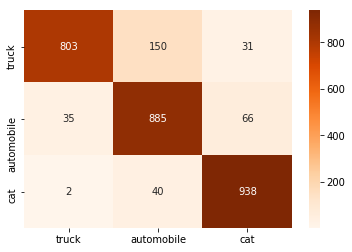

-----Adding a new class dog (total classes including other: 5)------
current other class: [1 3 5 7 8 9]
current target class: (10, 2, 4, 6)
all target target class: (10, 2, 4, 6)
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 30000
-----Fine Tuning------
GC (refining) accuracy on sequence ['truck', 'automobile', 'cat', 'dog']: [0.8029999911785126, 0.8339999973773956, 0.625, 0.639000004529953]


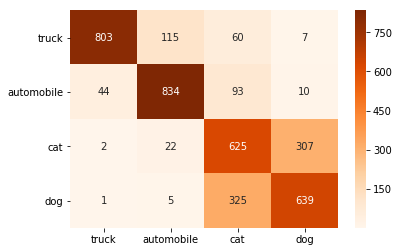


=====Training Using Growing Classifier (new classes never appeared in 'Other' class before) ======

current other class: [1 3 5 7 8 9]
current target class: (10,)
all target target class: (10, 2, 4, 6)
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 30000
-----Fine Tuning------
GC (without refining) accuracy on sequence ['truck']: [0.9650000154972076]


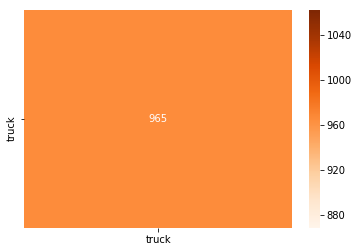

-----Adding a new class automobile (total classes including other: 3)------
current other class: [1 3 5 7 8 9]
current target class: (10, 2)
all target target class: (10, 2, 4, 6)
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 30000
-----Fine Tuning------
Epoch 00006: early stopping
GC (without refining) accuracy on sequence ['truck', 'automobile']: [0.8070000052452088, 0.6660000026226044]


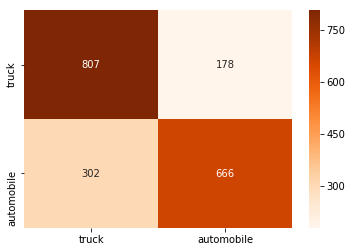

-----Adding a new class cat (total classes including other: 4)------
current other class: [1 3 5 7 8 9]
current target class: (10, 2, 4)
all target target class: (10, 2, 4, 6)
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 30000
-----Fine Tuning------
GC (without refining) accuracy on sequence ['truck', 'automobile', 'cat']: [0.7759999930858612, 0.6800000011920929, 0.8490000009536743]


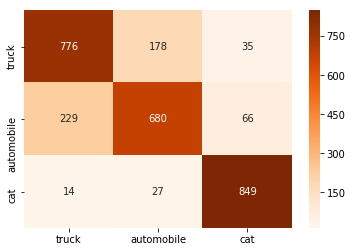

-----Adding a new class dog (total classes including other: 5)------
current other class: [1 3 5 7 8 9]
current target class: (10, 2, 4, 6)
all target target class: (10, 2, 4, 6)
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 30000
-----Fine Tuning------
Epoch 00007: early stopping
GC (without refining) accuracy on sequence ['truck', 'automobile', 'cat', 'dog']: [0.7300000011920929, 0.6970000088214874, 0.2720000043511391, 0.8]


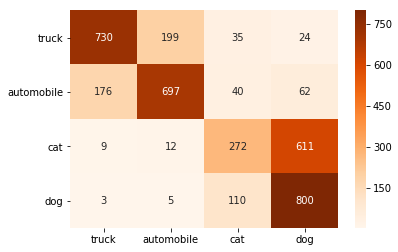

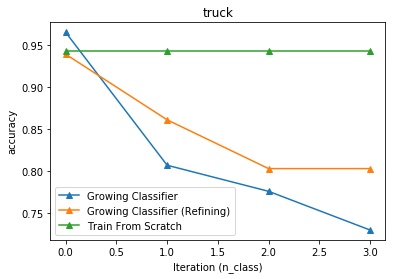

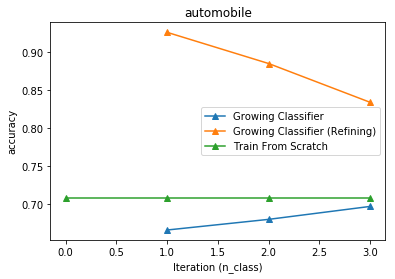

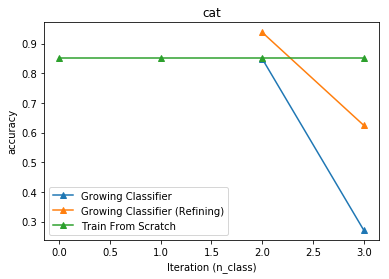

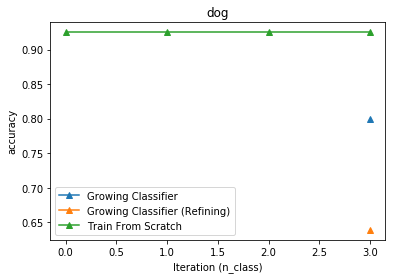

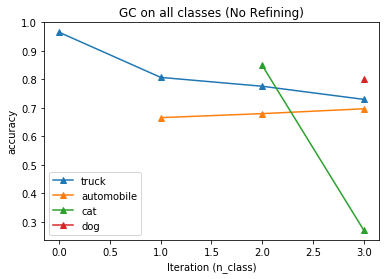

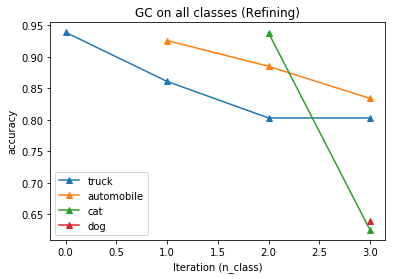

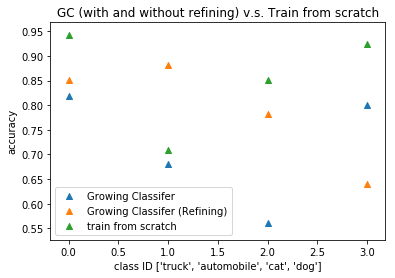

sequence of class addition: ['truck', 'automobile', 'dog', 'cat']

=====Training Using Growing Classifier (new classes appeared in 'Other' class before) ======

current other class: [1 2 3 4 5 6 7 8 9]
current target class: (10,)
all target target class: (10, 2, 6, 4)
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 45000
-----Fine Tuning------
GC (refining) accuracy on sequence ['truck']: [0.9539999961853027]


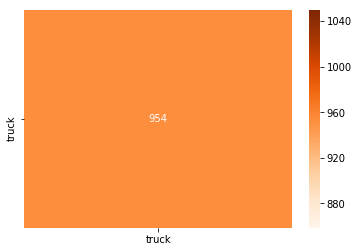

-----Adding a new class automobile (total classes including other: 3)------
current other class: [1 3 4 5 6 7 8 9]
current target class: (10, 2)
all target target class: (10, 2, 6, 4)
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 40000
-----Fine Tuning------
GC (refining) accuracy on sequence ['truck', 'automobile']: [0.8679999947547913, 0.8990000009536743]


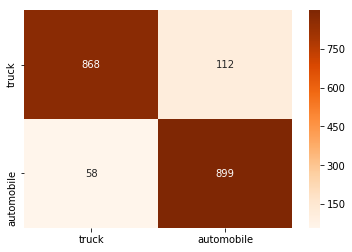

-----Adding a new class dog (total classes including other: 4)------
current other class: [1 3 4 5 7 8 9]
current target class: (10, 2, 6)
all target target class: (10, 2, 6, 4)
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 35000
-----Fine Tuning------
Epoch 00008: early stopping
GC (refining) accuracy on sequence ['truck', 'automobile', 'dog']: [0.8879999995231629, 0.8270000040531158, 0.939000004529953]


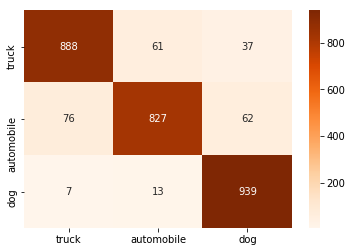

-----Adding a new class cat (total classes including other: 5)------
current other class: [1 3 5 7 8 9]
current target class: (10, 2, 6, 4)
all target target class: (10, 2, 6, 4)
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 30000
-----Fine Tuning------
GC (refining) accuracy on sequence ['truck', 'automobile', 'dog', 'cat']: [0.8569999992847442, 0.7669999957084656, 0.7710000038146972, 0.4459999978542328]


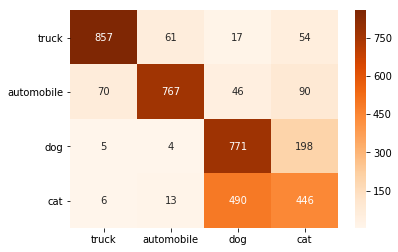


=====Training Using Growing Classifier (new classes never appeared in 'Other' class before) ======

current other class: [1 3 5 7 8 9]
current target class: (10,)
all target target class: (10, 2, 6, 4)
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 30000
-----Fine Tuning------
GC (without refining) accuracy on sequence ['truck']: [0.964000004529953]


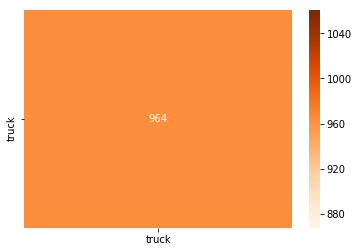

-----Adding a new class automobile (total classes including other: 3)------
current other class: [1 3 5 7 8 9]
current target class: (10, 2)
all target target class: (10, 2, 6, 4)
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 30000
-----Fine Tuning------
Epoch 00007: early stopping
GC (without refining) accuracy on sequence ['truck', 'automobile']: [0.7540000021457672, 0.6600000023841858]


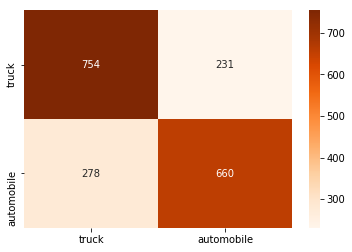

-----Adding a new class dog (total classes including other: 4)------
current other class: [1 3 5 7 8 9]
current target class: (10, 2, 6)
all target target class: (10, 2, 6, 4)
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 30000
-----Fine Tuning------
GC (without refining) accuracy on sequence ['truck', 'automobile', 'dog']: [0.7150000035762787, 0.686000007390976, 0.9569999992847442]


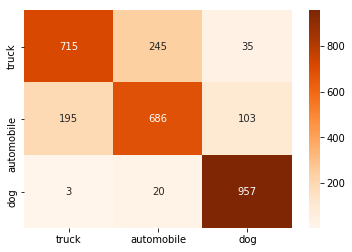

-----Adding a new class cat (total classes including other: 5)------
current other class: [1 3 5 7 8 9]
current target class: (10, 2, 6, 4)
all target target class: (10, 2, 6, 4)
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 30000
-----Fine Tuning------
Epoch 00006: early stopping
GC (without refining) accuracy on sequence ['truck', 'automobile', 'dog', 'cat']: [0.42399999797344207, 0.7890000104904175, 0.7550000011920929, 0.310000005364418]


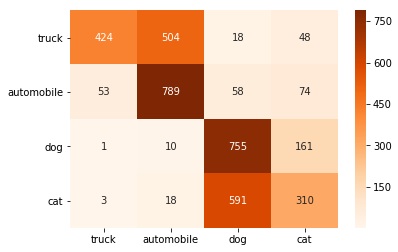

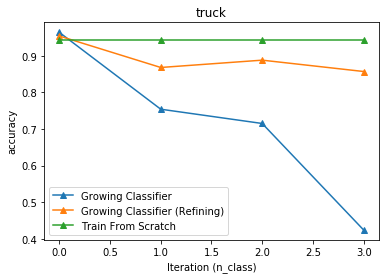

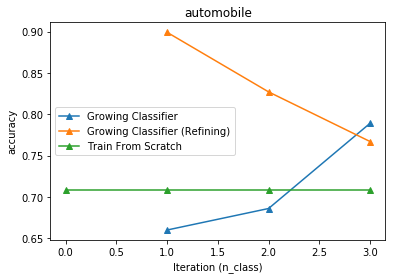

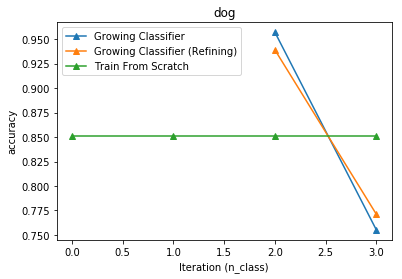

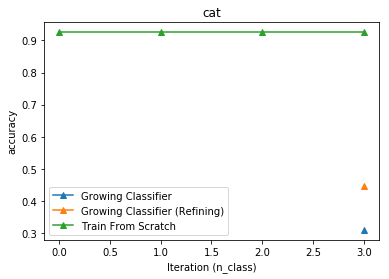

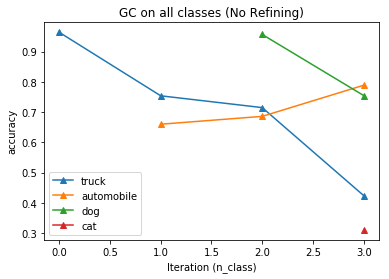

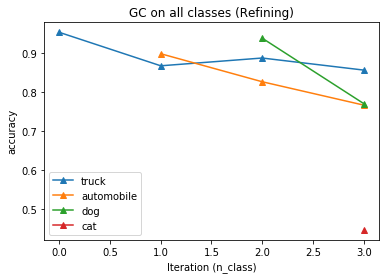

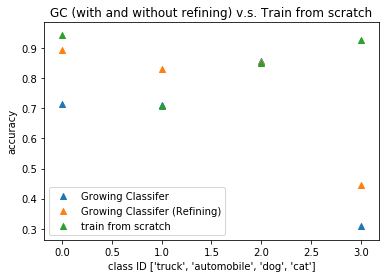

sequence of class addition: ['truck', 'cat', 'automobile', 'dog']

=====Training Using Growing Classifier (new classes appeared in 'Other' class before) ======

current other class: [1 2 3 4 5 6 7 8 9]
current target class: (10,)
all target target class: (10, 4, 2, 6)
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 45000
-----Fine Tuning------
GC (refining) accuracy on sequence ['truck']: [0.9490000009536743]


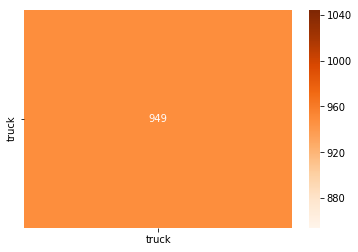

-----Adding a new class cat (total classes including other: 3)------
current other class: [1 2 3 5 6 7 8 9]
current target class: (10, 4)
all target target class: (10, 4, 2, 6)
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 40000
-----Fine Tuning------
Epoch 00010: early stopping
GC (refining) accuracy on sequence ['truck', 'cat']: [0.9099999964237213, 0.9129999995231628]


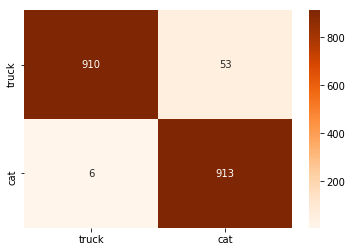

-----Adding a new class automobile (total classes including other: 4)------
current other class: [1 3 5 6 7 8 9]
current target class: (10, 4, 2)
all target target class: (10, 4, 2, 6)
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 35000
-----Fine Tuning------
Epoch 00010: early stopping
GC (refining) accuracy on sequence ['truck', 'cat', 'automobile']: [0.852999997138977, 0.9300000071525574, 0.7999999940395355]


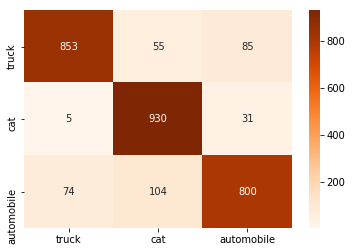

-----Adding a new class dog (total classes including other: 5)------
current other class: [1 3 5 7 8 9]
current target class: (10, 4, 2, 6)
all target target class: (10, 4, 2, 6)
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 30000
-----Fine Tuning------
GC (refining) accuracy on sequence ['truck', 'cat', 'automobile', 'dog']: [0.7949999928474426, 0.3760000020265579, 0.7629999995231629, 0.8110000014305114]


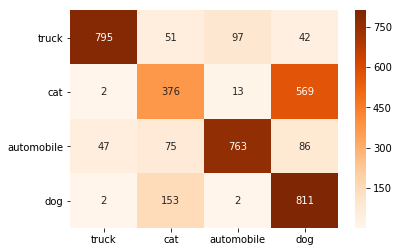


=====Training Using Growing Classifier (new classes never appeared in 'Other' class before) ======

current other class: [1 3 5 7 8 9]
current target class: (10,)
all target target class: (10, 4, 2, 6)
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 30000
-----Fine Tuning------
Epoch 00007: early stopping
GC (without refining) accuracy on sequence ['truck']: [0.9449999988079071]


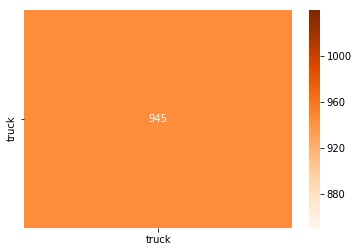

-----Adding a new class cat (total classes including other: 3)------
current other class: [1 3 5 7 8 9]
current target class: (10, 4)
all target target class: (10, 4, 2, 6)
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 30000
-----Fine Tuning------
Epoch 00008: early stopping
GC (without refining) accuracy on sequence ['truck', 'cat']: [0.8889999985694885, 0.9199999988079071]


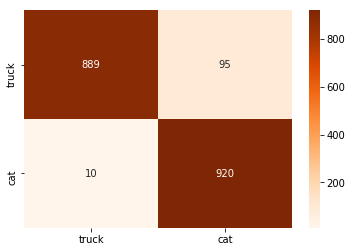

-----Adding a new class automobile (total classes including other: 4)------
current other class: [1 3 5 7 8 9]
current target class: (10, 4, 2)
all target target class: (10, 4, 2, 6)
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 30000
-----Fine Tuning------
GC (without refining) accuracy on sequence ['truck', 'cat', 'automobile']: [0.6839999973773956, 0.9209999978542328, 0.6779999971389771]


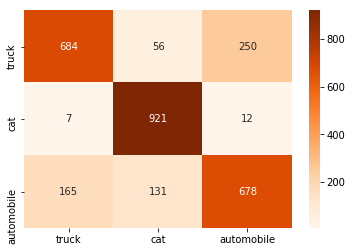

-----Adding a new class dog (total classes including other: 5)------
current other class: [1 3 5 7 8 9]
current target class: (10, 4, 2, 6)
all target target class: (10, 4, 2, 6)
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 30000
-----Fine Tuning------
GC (without refining) accuracy on sequence ['truck', 'cat', 'automobile', 'dog']: [0.6850000143051147, 0.4919999897480011, 0.6600000023841858, 0.6309999942779541]


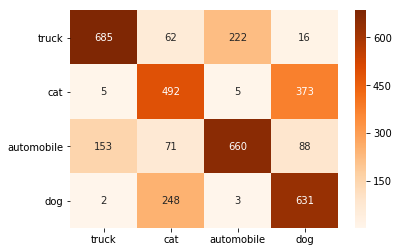

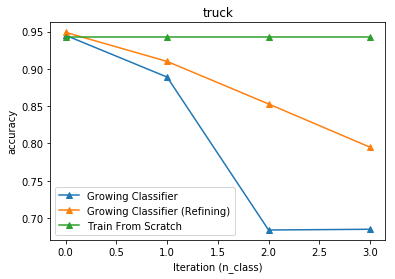

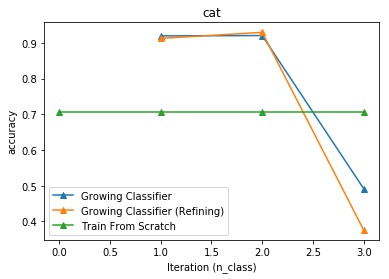

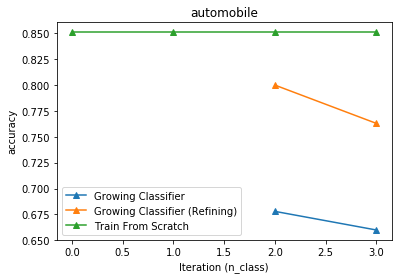

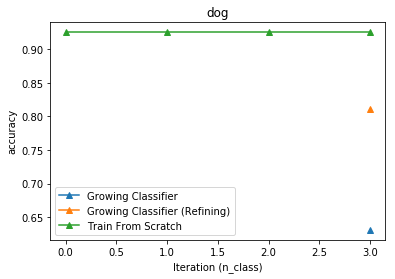

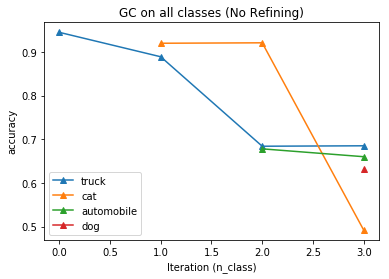

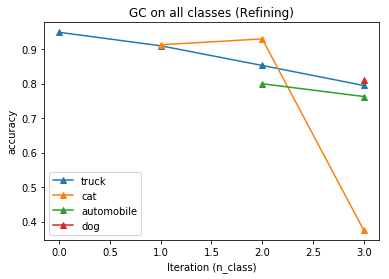

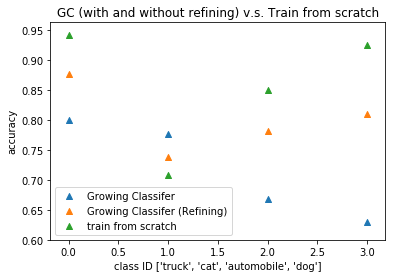

sequence of class addition: ['truck', 'cat', 'dog', 'automobile']

=====Training Using Growing Classifier (new classes appeared in 'Other' class before) ======

current other class: [1 2 3 4 5 6 7 8 9]
current target class: (10,)
all target target class: (10, 4, 6, 2)
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 45000
-----Fine Tuning------
Epoch 00007: early stopping
GC (refining) accuracy on sequence ['truck']: [0.9260000050067901]


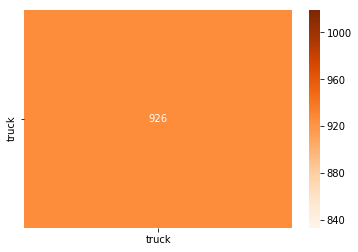

-----Adding a new class cat (total classes including other: 3)------
current other class: [1 2 3 5 6 7 8 9]
current target class: (10, 4)
all target target class: (10, 4, 6, 2)
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 40000
-----Fine Tuning------
Epoch 00009: early stopping
GC (refining) accuracy on sequence ['truck', 'cat']: [0.8919999957084656, 0.9280000030994415]


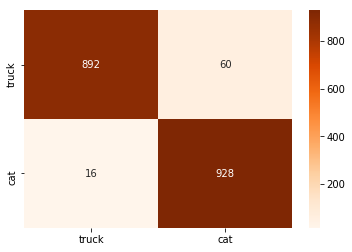

-----Adding a new class dog (total classes including other: 4)------
current other class: [1 2 3 5 7 8 9]
current target class: (10, 4, 6)
all target target class: (10, 4, 6, 2)
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 35000
-----Fine Tuning------
Epoch 00008: early stopping
GC (refining) accuracy on sequence ['truck', 'cat', 'dog']: [0.8589999973773956, 0.5049999982118607, 0.6870000123977661]


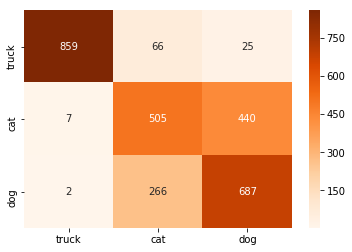

-----Adding a new class automobile (total classes including other: 5)------
current other class: [1 3 5 7 8 9]
current target class: (10, 4, 6, 2)
all target target class: (10, 4, 6, 2)
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 30000
-----Fine Tuning------
GC (refining) accuracy on sequence ['truck', 'cat', 'dog', 'automobile']: [0.8150000035762787, 0.46100000143051145, 0.722000002861023, 0.7579999983310699]


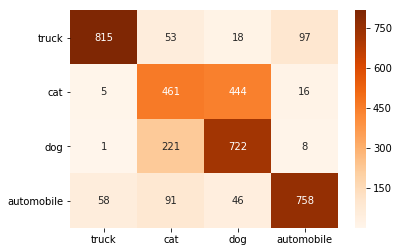


=====Training Using Growing Classifier (new classes never appeared in 'Other' class before) ======

current other class: [1 3 5 7 8 9]
current target class: (10,)
all target target class: (10, 4, 6, 2)
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 30000
-----Fine Tuning------
Epoch 00006: early stopping
GC (without refining) accuracy on sequence ['truck']: [0.9610000014305115]


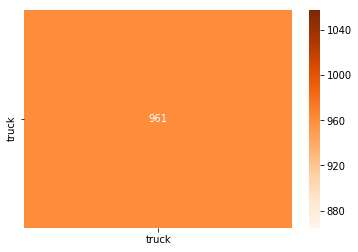

-----Adding a new class cat (total classes including other: 3)------
current other class: [1 3 5 7 8 9]
current target class: (10, 4)
all target target class: (10, 4, 6, 2)
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 30000
-----Fine Tuning------
Epoch 00009: early stopping
GC (without refining) accuracy on sequence ['truck', 'cat']: [0.9179999887943268, 0.8359999895095825]


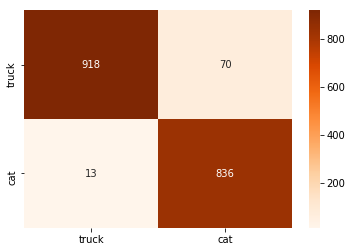

-----Adding a new class dog (total classes including other: 4)------
current other class: [1 3 5 7 8 9]
current target class: (10, 4, 6)
all target target class: (10, 4, 6, 2)
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 30000
-----Fine Tuning------
Epoch 00007: early stopping
GC (without refining) accuracy on sequence ['truck', 'cat', 'dog']: [0.8910000085830688, 0.48399999737739563, 0.49799999594688416]


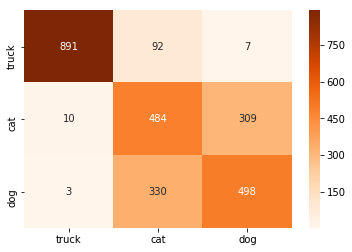

-----Adding a new class automobile (total classes including other: 5)------
current other class: [1 3 5 7 8 9]
current target class: (10, 4, 6, 2)
all target target class: (10, 4, 6, 2)
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 30000
-----Fine Tuning------
GC (without refining) accuracy on sequence ['truck', 'cat', 'dog', 'automobile']: [0.7660000026226044, 0.34400000274181364, 0.6880000114440918, 0.5770000040531158]


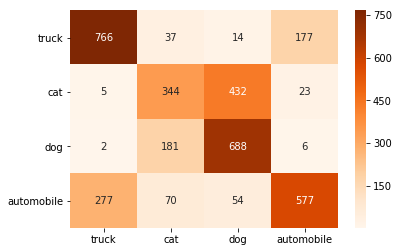

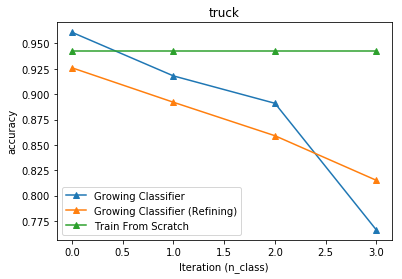

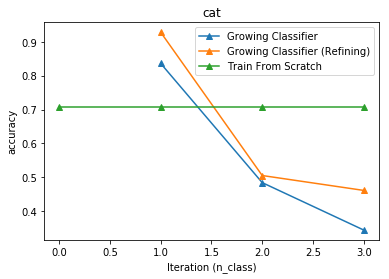

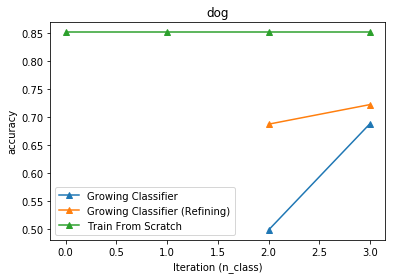

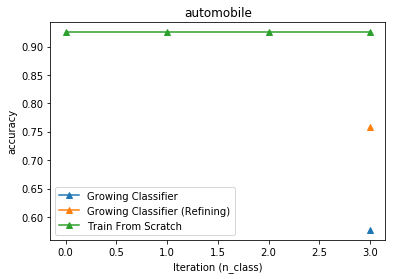

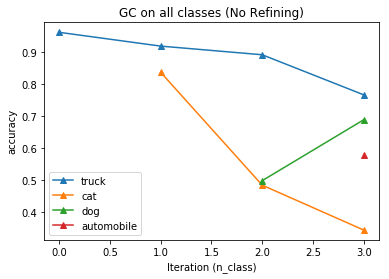

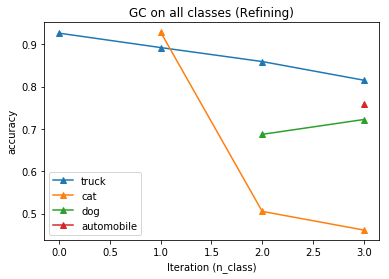

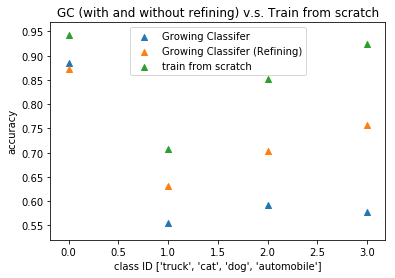

sequence of class addition: ['truck', 'dog', 'automobile', 'cat']

=====Training Using Growing Classifier (new classes appeared in 'Other' class before) ======

current other class: [1 2 3 4 5 6 7 8 9]
current target class: (10,)
all target target class: (10, 6, 2, 4)
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 45000
-----Fine Tuning------
Epoch 00008: early stopping
GC (refining) accuracy on sequence ['truck']: [0.9550000071525574]


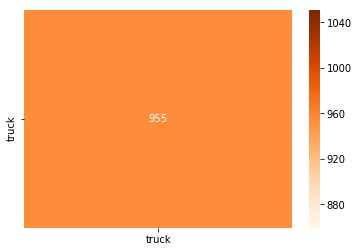

-----Adding a new class dog (total classes including other: 3)------
current other class: [1 2 3 4 5 7 8 9]
current target class: (10, 6)
all target target class: (10, 6, 2, 4)
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 40000
-----Fine Tuning------
GC (refining) accuracy on sequence ['truck', 'dog']: [0.9289999961853027, 0.886000007390976]


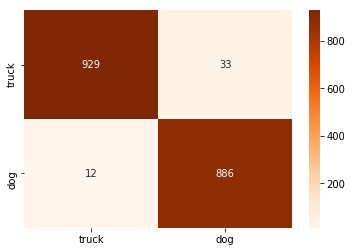

-----Adding a new class automobile (total classes including other: 4)------
current other class: [1 3 4 5 7 8 9]
current target class: (10, 6, 2)
all target target class: (10, 6, 2, 4)
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 35000
-----Fine Tuning------
Epoch 00006: early stopping
GC (refining) accuracy on sequence ['truck', 'dog', 'automobile']: [0.8699999988079071, 0.8899999916553497, 0.8110000014305114]


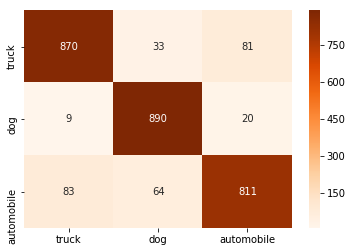

-----Adding a new class cat (total classes including other: 5)------
current other class: [1 3 5 7 8 9]
current target class: (10, 6, 2, 4)
all target target class: (10, 6, 2, 4)
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 30000
-----Fine Tuning------
GC (refining) accuracy on sequence ['truck', 'dog', 'automobile', 'cat']: [0.8199999928474426, 0.4459999978542328, 0.8, 0.7199999988079071]


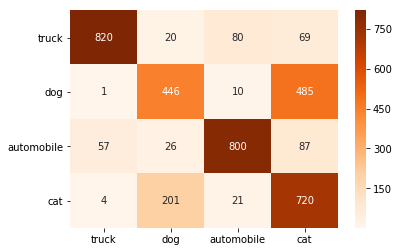


=====Training Using Growing Classifier (new classes never appeared in 'Other' class before) ======

current other class: [1 3 5 7 8 9]
current target class: (10,)
all target target class: (10, 6, 2, 4)
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 30000
-----Fine Tuning------
GC (without refining) accuracy on sequence ['truck']: [0.9660000085830689]


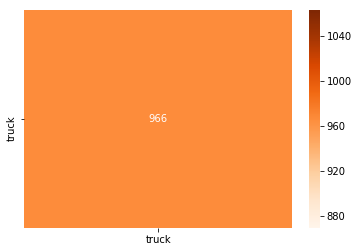

-----Adding a new class dog (total classes including other: 3)------
current other class: [1 3 5 7 8 9]
current target class: (10, 6)
all target target class: (10, 6, 2, 4)
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 30000
-----Fine Tuning------
Epoch 00007: early stopping
GC (without refining) accuracy on sequence ['truck', 'dog']: [0.9210000097751617, 0.9770000100135803]


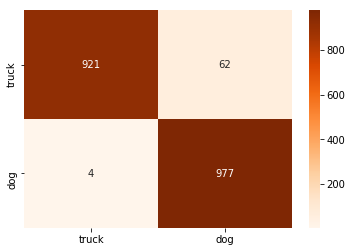

-----Adding a new class automobile (total classes including other: 4)------
current other class: [1 3 5 7 8 9]
current target class: (10, 6, 2)
all target target class: (10, 6, 2, 4)
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 30000
-----Fine Tuning------
GC (without refining) accuracy on sequence ['truck', 'dog', 'automobile']: [0.7569999992847443, 0.9270000040531159, 0.7439999997615814]


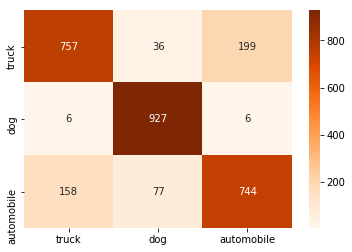

-----Adding a new class cat (total classes including other: 5)------
current other class: [1 3 5 7 8 9]
current target class: (10, 6, 2, 4)
all target target class: (10, 6, 2, 4)
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 30000
-----Fine Tuning------
Epoch 00007: early stopping
GC (without refining) accuracy on sequence ['truck', 'dog', 'automobile', 'cat']: [0.7719999969005584, 0.5800000011920929, 0.598999997973442, 0.6209999978542328]


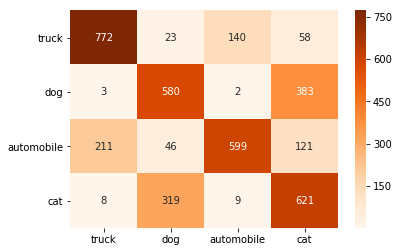

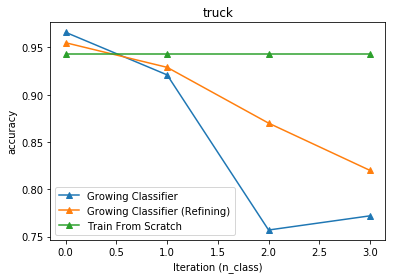

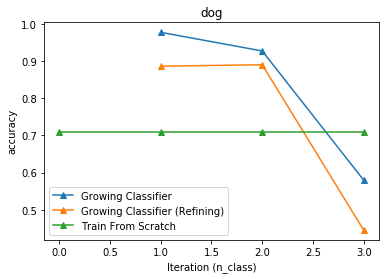

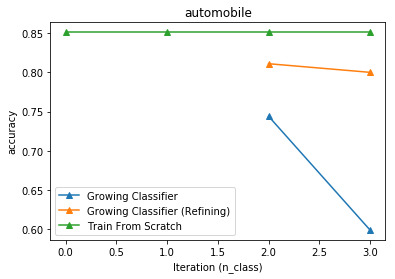

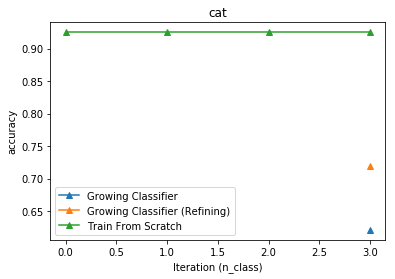

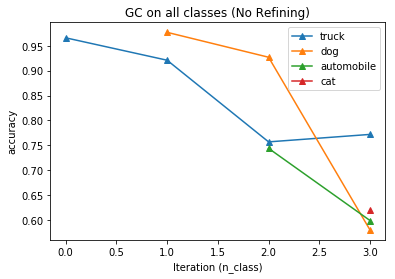

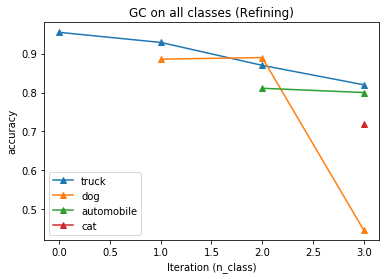

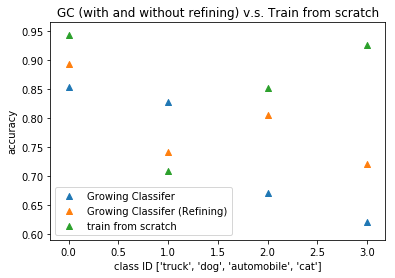

sequence of class addition: ['truck', 'dog', 'cat', 'automobile']

=====Training Using Growing Classifier (new classes appeared in 'Other' class before) ======

current other class: [1 2 3 4 5 6 7 8 9]
current target class: (10,)
all target target class: (10, 6, 4, 2)
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 45000
-----Fine Tuning------
Epoch 00007: early stopping
GC (refining) accuracy on sequence ['truck']: [0.939000004529953]


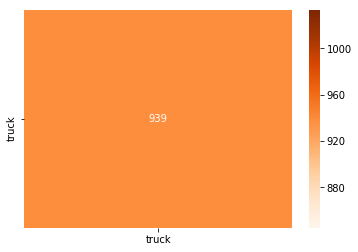

-----Adding a new class dog (total classes including other: 3)------
current other class: [1 2 3 4 5 7 8 9]
current target class: (10, 6)
all target target class: (10, 6, 4, 2)
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 40000
-----Fine Tuning------
GC (refining) accuracy on sequence ['truck', 'dog']: [0.9050000011920929, 0.9200000047683716]


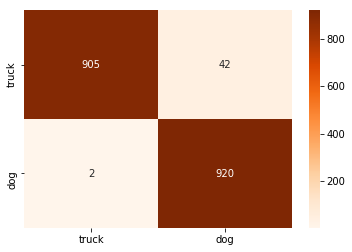

-----Adding a new class cat (total classes including other: 4)------
current other class: [1 2 3 5 7 8 9]
current target class: (10, 6, 4)
all target target class: (10, 6, 4, 2)
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 35000
-----Fine Tuning------
Epoch 00006: early stopping
GC (refining) accuracy on sequence ['truck', 'dog', 'cat']: [0.8339999914169312, 0.45499999523162843, 0.6860000014305114]


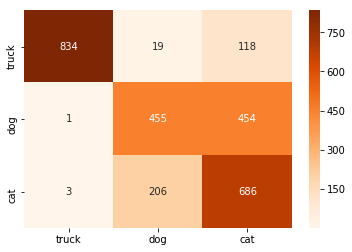

-----Adding a new class automobile (total classes including other: 5)------
current other class: [1 3 5 7 8 9]
current target class: (10, 6, 4, 2)
all target target class: (10, 6, 4, 2)
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 30000
-----Fine Tuning------
Epoch 00006: early stopping
GC (refining) accuracy on sequence ['truck', 'dog', 'cat', 'automobile']: [0.8030000030994415, 0.64200000166893, 0.5640000015497207, 0.6860000014305114]


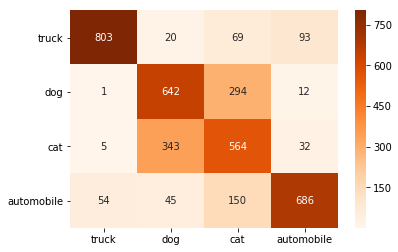


=====Training Using Growing Classifier (new classes never appeared in 'Other' class before) ======

current other class: [1 3 5 7 8 9]
current target class: (10,)
all target target class: (10, 6, 4, 2)
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 30000
-----Fine Tuning------
Epoch 00008: early stopping
GC (without refining) accuracy on sequence ['truck']: [0.9620000004768372]


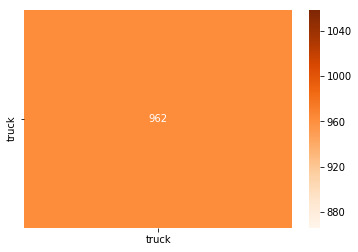

-----Adding a new class dog (total classes including other: 3)------
current other class: [1 3 5 7 8 9]
current target class: (10, 6)
all target target class: (10, 6, 4, 2)
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 30000
-----Fine Tuning------
Epoch 00008: early stopping
GC (without refining) accuracy on sequence ['truck', 'dog']: [0.886000007390976, 0.7329999923706054]


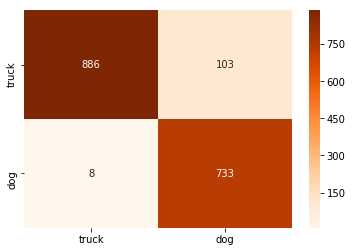

-----Adding a new class cat (total classes including other: 4)------
current other class: [1 3 5 7 8 9]
current target class: (10, 6, 4)
all target target class: (10, 6, 4, 2)
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 30000
-----Fine Tuning------
Epoch 00006: early stopping
GC (without refining) accuracy on sequence ['truck', 'dog', 'cat']: [0.85799999833107, 0.6540000021457673, 0.42499999701976776]


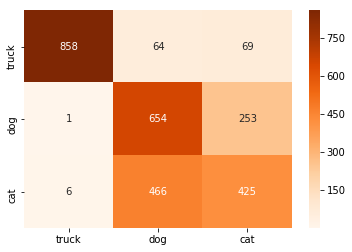

-----Adding a new class automobile (total classes including other: 5)------
current other class: [1 3 5 7 8 9]
current target class: (10, 6, 4, 2)
all target target class: (10, 6, 4, 2)
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 30000
-----Fine Tuning------
GC (without refining) accuracy on sequence ['truck', 'dog', 'cat', 'automobile']: [0.5000000029802323, 0.3200000002980232, 0.6879999995231628, 0.7090000033378601]


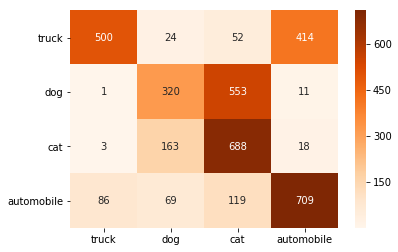

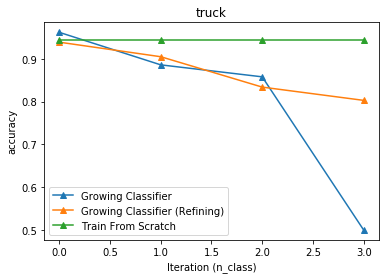

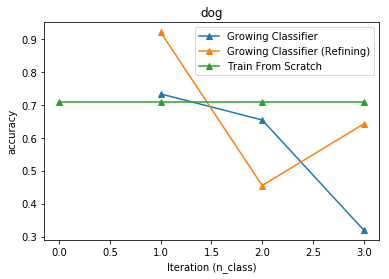

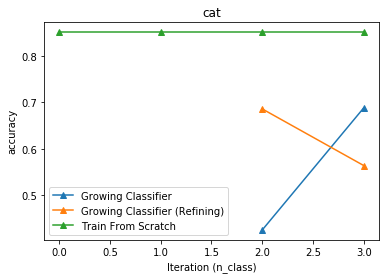

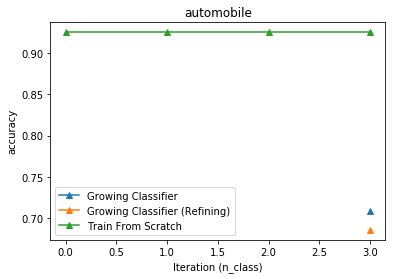

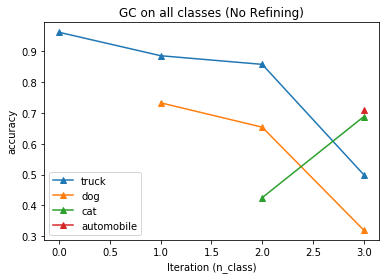

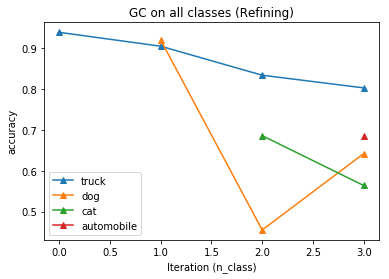

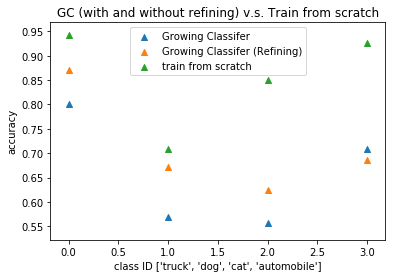

In [5]:
num_classes_excluding_other = 4
base_epochs = 10
# full_target_class_ids = full_class_ids[:num_classes_excluding_other]
full_target_class_ids = np.array([2, 4, 6, 10])
selected_class_names = [class_names[el] for el in full_target_class_ids]
print('selected classes: ' + str(selected_class_names))

full_target_class_ids_all_permutation = list(itertools.permutations(full_target_class_ids))

cur_target_class_ids = np.copy(full_target_class_ids)

GC_refining_results = []
GC_results = []
from_scratch_results = []
from_scratch_result, _, _ = cifar10_utils.one_run(model, x_train, y_train, 
                                            x_test, y_test, batch_size, full_target_class_ids, 
                                            initial_weights, base_epochs, class_names, GC=False)
from_scratch_results += [from_scratch_result]

for full_target_class_ids_eli in full_target_class_ids_all_permutation: 
    print('sequence of class addition: ' + str([class_names[el] for el in full_target_class_ids_eli]))
    _, GC_refining_result, GC_result = cifar10_utils.one_run(model, x_train, y_train, 
                                                x_test, y_test, batch_size, full_target_class_ids_eli, 
                                                initial_weights, base_epochs, class_names, GC=True)
    cifar10_utils.plot_result(from_scratch_result, GC_result, GC_refining_result, full_target_class_ids_eli, 
                              class_names)
    GC_refining_results += [GC_refining_result]
    GC_results += [GC_result]

In [6]:
import pickle

with open('GC_results_automobile_dog_truck_cat_early_stopping.pkl', 'wb') as f:
    pickle.dump(GC_results, f)

with open('GC_refining_results_automobile_dog_truck_cat_early_stopping.pkl', 'wb') as f:
    pickle.dump(GC_refining_results, f)

with open('from_scratch_results_automobile_dog_truck_cat_early_stopping.pkl', 'wb') as f:
    pickle.dump(from_scratch_results, f)